### Necessary imports

In [332]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import dask.dataframe as dd
import collections
from scipy import stats
from pylab import rcParams

rcParams['figure.figsize'] = 6, 6
sns.set(context='notebook', style='whitegrid', palette="Dark2", font='sans-serif', font_scale=1, color_codes=True, rc=None)

import random
random.seed(42)

from sklearn.feature_selection import SelectFromModel, SelectKBest, mutual_info_classif, RFE
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline, Pipeline


from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score, cross_val_predict, StratifiedKFold, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import roc_curve, roc_auc_score, f1_score, accuracy_score, classification_report, precision_score, recall_score, make_scorer

from sklearn.exceptions import UndefinedMetricWarning, ConvergenceWarning
import warnings
warnings.filterwarnings(action='ignore', category=UndefinedMetricWarning)
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter('ignore', FutureWarning)


### Data uploading

In [2]:
X = pd.read_csv('X2010.csv', header=None, dtype='float16')
y = pd.read_csv('y2010.csv', header=None, dtype='int8')

In [3]:
X = X.drop(0, axis=1)

In [4]:
X.isna().sum().sum()

0

In [5]:
y = y.drop(0, axis=1)

In [6]:
y = np.array(y).ravel()

In [7]:
X.shape

(16715, 5408)

In [8]:
y.shape

(16715,)

### Data standarization

In [9]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

### Examinig  baseline models
* Logistic Regression with default settings
* Logistic Regression with class weights
* Logistic Regression with Lasso regularization

Because of the imbalanced data it is not the best idea to evaluate models using accuracy. F1 score would be a better measure. 
Moreover, as I have found in cited articles, to find new cancer rescue mutants effectively true positives (tp) are more important than true negatives (tn) for the classifier to be useful. Therefore, a good way to evaluate a classifier is to use the Positive Predictive Value (PPV), as well as F1. 

That is why I decided to use F1 and precision (as a second measure) to evaluate classifiers.

#### Train/test split

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [11]:
y_test.shape

(3343,)

In [12]:
def plot_roc_curve(y_true, y_pred_proba):
    fpr, tpr, thresholds = roc_curve(y_true=y_true,
                                     y_score=y_pred_proba)

    plt.plot(fpr, tpr)
    plt.scatter(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.plot([0, 1], [0, 1], linestyle='--')
    auc = roc_auc_score(y_true=y_true,
                        y_score=y_pred_proba)
    plt.title('AUC: {:.5f}'.format(auc))
    plt.show()

In [13]:
def get_f1_thresholds(y_true, y_pred):
    thresholds = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.66, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 0.999, 0.9999, 0.999]
    precision_scores = [] # jakie P ze jesli model powiedzial, ze fraud to naprawde fraud
    f1_scores = []   # jak duzo sposrod fraudow wykrylismy
    recall_scores = [] 
    
    for t in thresholds:
        f1_scores.append(f1_score(y_true, (y_pred>t)))    
        precision_scores.append(precision_score(y_true, (y_pred>t))) 
        recall_scores.append(recall_score(y_true, (y_pred>t))) 
        
        
        
    return pd.DataFrame({'threshold': thresholds, 'F1': f1_scores, 'PPV': precision_scores,'TPR': recall_scores })

In [14]:
def get_best_threshold_for_F1(y_true, y_pred_prob, thresholds_number = 500):
    thresholds = np.linspace(start=0, stop=1, num=thresholds_number).tolist()
    f1_scores = []

    for t in thresholds:
        f1_scores.append(f1_score(y_true, (y_pred_prob>t)))

    scores_df = pd.DataFrame({'threshold': thresholds, 'F1': f1_scores})
    return scores_df[scores_df.F1 == scores_df.F1.max()]['threshold'].iloc[0]

In [21]:
def get_best_threshold_for_precision(y_true, y_pred_prob, thresholds_number = 500):
    thresholds = np.linspace(start=0, stop=1, num=thresholds_number).tolist()
    precision_scores = []

    for t in thresholds:
        precision_scores.append(precision_score(y_true, (y_pred_prob>t)))

    scores_df = pd.DataFrame({'threshold': thresholds, 'PRECISION': precision_scores})
    return scores_df[scores_df.PRECISION == scores_df.PRECISION.max()]['threshold'].iloc[0]

In [ ]:
rcParams['figure.figsize'] = 6, 6

#### Logistic Regression with default settings

In [16]:
model_lr = LogisticRegression()
model_lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

Train set results:

In [17]:
y_pred_proba_train_lr = model_lr.predict_proba(X_train)[:, 1]

In [18]:
print(classification_report(y_train, (y_pred_proba_train_lr > 0.5)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     13258
           1       1.00      1.00      1.00       114

    accuracy                           1.00     13372
   macro avg       1.00      1.00      1.00     13372
weighted avg       1.00      1.00      1.00     13372



Next, we can find optimal threshold maximizing F1 score.

In [19]:
threshold_f1 = get_best_threshold_for_F1(y_train, y_pred_proba_train_lr)
f1 = f1_score(y_train, (y_pred_proba_train_lr > threshold_f1))
print('Max F1 score: {:.4f} for threshold: {:.4f}'.format(f1, threshold_f1))

Max F1 score: 1.0000 for threshold: 0.2144


In [45]:
threshold_precision = get_best_threshold_for_precision(y_train, y_pred_proba_train_lr)
precision = precision_score(y_train, (y_pred_proba_train_lr > threshold_precision))
print('Max precision score: {:.4f} for threshold: {:.4f}'.format(precision, threshold_precision))

Max precision score: 1.0000 for threshold: 0.2144


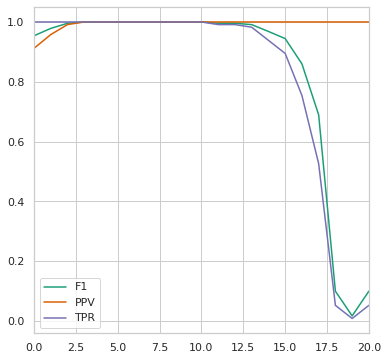

In [138]:
results_lr_tr = get_f1_thresholds(y_train, y_pred_proba_train_lr)
results_lr_tr[['F1','PPV','TPR']].plot()
plt.show()

Test set results:

In [30]:
y_pred_proba_test_lr = model_lr.predict_proba(X_test)[:, 1]

In [31]:
print(classification_report(y_test, (y_pred_proba_test_lr > 0.5)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3314
           1       0.48      0.48      0.48        29

    accuracy                           0.99      3343
   macro avg       0.74      0.74      0.74      3343
weighted avg       0.99      0.99      0.99      3343



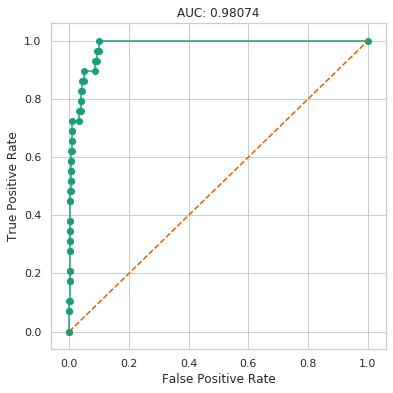

In [137]:
plot_roc_curve(y_test, y_pred_proba_test_lr)

In [33]:
threshold_f1 = get_best_threshold_for_F1(y_test, y_pred_proba_test_lr)
f1 = f1_score(y_test, (y_pred_proba_test_lr > threshold_f1))
print('Test set F1 score: {:.4f} for threshold: {:.4f}'.format(f1, threshold_f1))

Test set F1 score: 0.5246 for threshold: 0.3948


In [44]:
threshold_precision = get_best_threshold_for_precision(y_test, y_pred_proba_test_lr)
precision = precision_score(y_test, (y_pred_proba_test_lr > threshold_precision))
print('Max precision score: {:.4f} for threshold: {:.4f}'.format(precision, threshold_precision))

Max precision score: 0.6250 for threshold: 0.9860


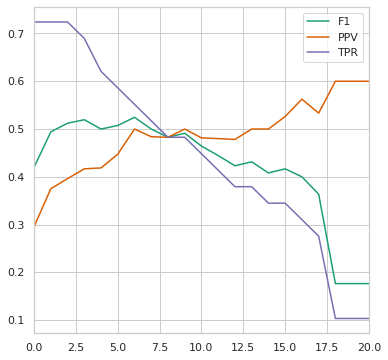

In [136]:
results_lr_te = get_f1_thresholds(y_test, y_pred_proba_test_lr)
results_lr_te[['F1','PPV','TPR']].plot()
plt.show()

In [36]:
results_lr_te

,threshold,F1,PPV,TPR
0,0.1000,0.420000,0.295775,0.724138
1,0.1500,0.494118,0.375000,0.724138
2,0.2000,0.512195,0.396226,0.724138
3,0.2500,0.519481,0.416667,0.689655
4,0.3000,0.500000,0.418605,0.620690
5,0.3500,0.507463,0.447368,0.586207
6,0.4000,0.524590,0.500000,0.551724
7,0.4500,0.500000,0.483871,0.517241
8,0.5000,0.482759,0.482759,0.482759
9,0.5500,0.491228,0.500000,0.482759


#### Logistic Regression with class weights

In [37]:
imbalance_ratio = len(np.where(y_train == 0)[0]) / len(np.where(y_train == 1)[0])

In [38]:
model_lrw = LogisticRegression(class_weight={0: 1, 1: imbalance_ratio})
model_lrw.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight={0: 1, 1: 116.29824561403508},
                   dual=False, fit_intercept=True, intercept_scaling=1,
                   l1_ratio=None, max_iter=100, multi_class='warn', n_jobs=None,
                   penalty='l2', random_state=None, solver='warn', tol=0.0001,
                   verbose=0, warm_start=False)

Train set results:

In [39]:
y_pred_proba_train_lrw = model_lrw.predict_proba(X_train)[:, 1]

In [40]:
print(classification_report(y_train, (y_pred_proba_train_lrw > 0.5)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     13258
           1       1.00      1.00      1.00       114

    accuracy                           1.00     13372
   macro avg       1.00      1.00      1.00     13372
weighted avg       1.00      1.00      1.00     13372



In [41]:
threshold_f1 = get_best_threshold_for_F1(y_train, y_pred_proba_train_lrw)
f1 = f1_score(y_train, (y_pred_proba_train_lrw > threshold_f1))
print('Max F1 score: {:.4f} for threshold: {:.4f}'.format(f1, threshold_f1))

Max F1 score: 1.0000 for threshold: 0.4208


In [52]:
threshold_precision = get_best_threshold_for_precision(y_train, y_pred_proba_train_lrw)
precision = precision_score(y_train, (y_pred_proba_train_lrw > threshold_precision))
print('Max precision score: {:.4f} for threshold: {:.4f}'.format(precision, threshold_precision))

Max precision score: 1.0000 for threshold: 0.4208


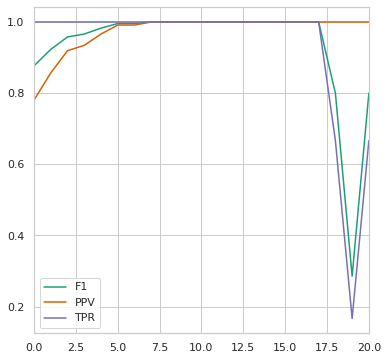

In [135]:
results_lrw_te = get_f1_thresholds(y_train, y_pred_proba_train_lrw)
results_lrw_te[['F1','PPV','TPR']].plot()
plt.show()

Test set results:

In [46]:
y_pred_proba_test_lrw = model_lrw.predict_proba(X_test)[:, 1]

In [47]:
print(classification_report(y_test, (y_pred_proba_test_lrw > 0.5)))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99      3314
           1       0.30      0.72      0.42        29

    accuracy                           0.98      3343
   macro avg       0.65      0.85      0.71      3343
weighted avg       0.99      0.98      0.99      3343



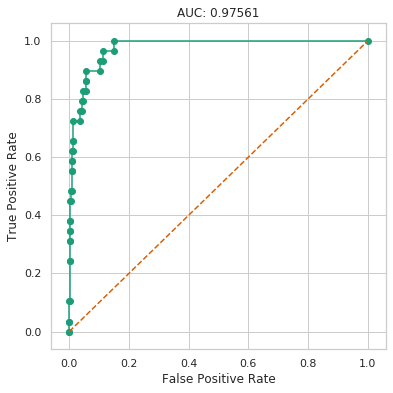

In [134]:
plot_roc_curve(y_test, y_pred_proba_test_lrw)

In [49]:
threshold_f1 = get_best_threshold_for_F1(y_test, y_pred_proba_test_lrw)
f1 = f1_score(y_test, (y_pred_proba_test_lrw > threshold_f1))
print('Test set F1 score: {:.4f} for threshold: {:.4f}'.format(f1, threshold_f1))

Test set F1 score: 0.4727 for threshold: 0.9800


In [53]:
threshold_precision = get_best_threshold_for_precision(y_test, y_pred_proba_test_lrw)
precision = precision_score(y_test, (y_pred_proba_test_lrw > threshold_precision))
print('Test set precision score: {:.4f} for threshold: {:.4f}'.format(precision, threshold_f1))

Test set precision score: 0.5000 for threshold: 0.9800


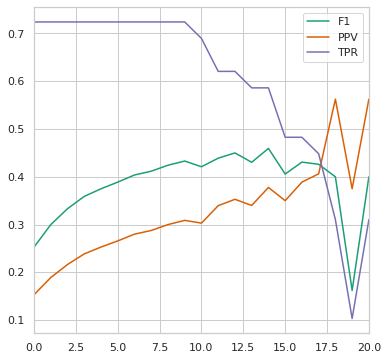

In [133]:
results_lrw_te = get_f1_thresholds(y_test, y_pred_proba_test_lrw)
results_lrw_te[['F1','PPV','TPR']].plot()
plt.show()

In [55]:
results_lrw_te

,threshold,F1,PPV,TPR
0,0.1000,0.253012,0.153285,0.724138
1,0.1500,0.300000,0.189189,0.724138
2,0.2000,0.333333,0.216495,0.724138
3,0.2500,0.358974,0.238636,0.724138
4,0.3000,0.375000,0.253012,0.724138
5,0.3500,0.388889,0.265823,0.724138
6,0.4000,0.403846,0.280000,0.724138
7,0.4500,0.411765,0.287671,0.724138
8,0.5000,0.424242,0.300000,0.724138
9,0.5500,0.432990,0.308824,0.724138


#### Logistic regression with Lasso regularization

In [56]:
model_lrl = LogisticRegression(penalty='l1')
model_lrl.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

Train set results:

In [57]:
y_pred_proba_train_lrl = model_lrl.predict_proba(X_train)[:, 1]

In [58]:
print(classification_report(y_train, (y_pred_proba_train_lrl > 0.5)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     13258
           1       0.99      0.95      0.97       114

    accuracy                           1.00     13372
   macro avg       1.00      0.97      0.98     13372
weighted avg       1.00      1.00      1.00     13372



In [59]:
threshold_f1 = get_best_threshold_for_F1(y_train, y_pred_proba_train_lrl)
f1 = f1_score(y_train, (y_pred_proba_train_lrl > threshold_f1))
print('Max F1 score: {:.4f} for threshold: {:.4f}'.format(f1, threshold_f1))

Max F1 score: 0.9825 for threshold: 0.3928


In [60]:
threshold_precision = get_best_threshold_for_precision(y_train, y_pred_proba_train_lrl)
precision = precision_score(y_train, (y_pred_proba_train_lrl > threshold_precision))
print('Max precision score: {:.4f} for threshold: {:.4f}'.format(precision, threshold_precision))

Max precision score: 1.0000 for threshold: 0.5752


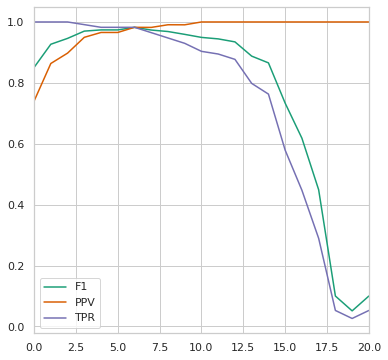

In [132]:
results_lrl_tr = get_f1_thresholds(y_train, y_pred_proba_train_lrl)
results_lrl_tr[['F1','PPV','TPR']].plot()
plt.show()

Test set results:


In [62]:
y_pred_proba_test_lrl = model_lrl.predict_proba(X_test)[:, 1]

In [63]:
print(classification_report(y_test, (y_pred_proba_test_lrl > 0.5)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3314
           1       0.70      0.55      0.62        29

    accuracy                           0.99      3343
   macro avg       0.85      0.77      0.81      3343
weighted avg       0.99      0.99      0.99      3343



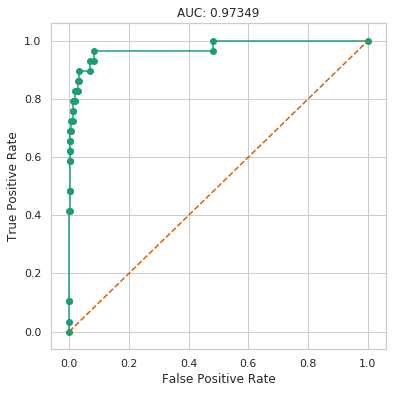

In [131]:
plot_roc_curve(y_test, y_pred_proba_test_lrl)

In [65]:
threshold_f1 = get_best_threshold_for_F1(y_test, y_pred_proba_test_lrl)
f1 = f1_score(y_test, (y_pred_proba_test_lrl > threshold_f1))
print('Test set F1 score: {:.4f} for threshold: {:.4f}'.format(f1, threshold_f1))

Test set F1 score: 0.6545 for threshold: 0.4489


In [66]:
threshold_precision = get_best_threshold_for_precision(y_test, y_pred_proba_test_lrl)
precision = precision_score(y_test, (y_pred_proba_test_lrl > threshold_precision))
print('Test set precision score: {:.4f} for threshold: {:.4f}'.format(precision, threshold_precision))

Test set precision score: 0.9231 for threshold: 0.9459


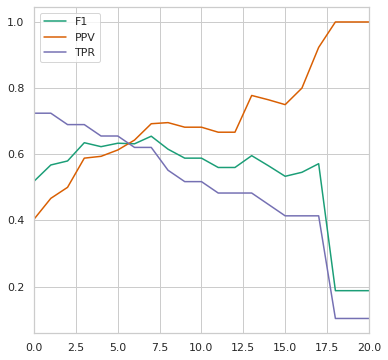

In [130]:
results_lrl_te = get_f1_thresholds(y_test, y_pred_proba_test_lrl)
results_lrl_te[['F1','PPV','TPR']].plot()
plt.show()

In [68]:
linear_importances = model_lrl.coef_.ravel()

In [69]:
(linear_importances != 0).astype(int).sum()

350

In [70]:
np.where(linear_importances != 0)[0]

array([   0,   11,   54,   59,   72,   78,   79,  101,  105,  133,  136,
        161,  173,  226,  235,  278,  306,  308,  321,  337,  348,  364,
        392,  405,  420,  444,  451,  461,  485,  544,  549,  555,  658,
        660,  665,  724,  736,  751,  756,  762,  770,  799,  812,  813,
        856,  888,  928,  939,  960,  968,  969,  977,  999, 1002, 1005,
       1035, 1048, 1058, 1082, 1084, 1089, 1098, 1119, 1135, 1140, 1150,
       1166, 1182, 1187, 1193, 1230, 1248, 1278, 1340, 1425, 1437, 1457,
       1479, 1483, 1505, 1512, 1513, 1590, 1594, 1603, 1604, 1606, 1611,
       1617, 1636, 1674, 1706, 1712, 1722, 1819, 1839, 1850, 1858, 1864,
       1872, 1878, 1885, 1962, 1965, 1968, 1982, 1983, 1985, 2006, 2029,
       2033, 2034, 2037, 2061, 2071, 2107, 2109, 2116, 2127, 2128, 2180,
       2204, 2207, 2208, 2225, 2237, 2294, 2324, 2381, 2390, 2402, 2408,
       2409, 2412, 2413, 2443, 2477, 2478, 2519, 2520, 2575, 2583, 2607,
       2634, 2638, 2639, 2643, 2654, 2765, 2766, 27

All baseline models seem to be overfitted (models are performing much better on training sets than on test sets).

It is probably because of a large number of features. I need to reduce it for further analysis.

### Preliminary features selection with SelectKBest

Due to a lack of memory I will select features with SelectKBest on 4 parts of a dataset separately and I will select most common features from all datasets.


In [71]:
def SKB_col_selector(score_func, k, X, Y):
    cols_sum = []
    for x, y in zip(X, Y):
        selector = SelectKBest(score_func, k=k)
    
        selector.fit(x, y)

        cols = selector.get_support(indices=True)
        cols_sum.extend(cols.tolist())
    
    import collections
    counter=collections.Counter(cols_sum)
    most_common = []
    
    for tuple in counter.most_common(k):
        most_common.append(tuple[0])
    most_common.sort()
    print(len(most_common))
    print(most_common) 
    return cols_sum, most_common
     

In [72]:
X1 = X[:5000,:]
y1 = y[:5000]
X2 = X[5000:10000,:]
y2 = y[5000:10000]
X3 = X[10000:15000,:]
y3 = y[10000:15000]
X4 = X[15000:,:]
y4 = y[15000:]

In [73]:
X_sum = [X1, X2, X3, X4]
y_sum = [y1, y2, y3, y4]

In [28]:
for i in [50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550]:
    SKB_col_selected = SKB_col_selector(mutual_info_classif, k=i, X=X_sum, Y=y_sum)
    most_common = SKB_col_selected[1]
    X_most_common = pd.DataFrame(X)[most_common]
    
    X_train, X_test, y_train, y_test = train_test_split(X_most_common, y, test_size=0.2, stratify=y, random_state=42)
    model_lr = LogisticRegression()
    model_lr.fit(X_train, y_train)
    
    y_pred_proba_train_bs = model_lr.predict_proba(X_train)[:, 1]
    y_pred_proba_test_bs = model_lr.predict_proba(X_test)[:, 1]
    
    threshold_f1 = get_best_threshold_for_F1(y_train, y_pred_proba_train_bs)
    f1 = f1_score(y_train, (y_pred_proba_train_bs > threshold_f1))
    print(str(i))
    print('Max F1 score: {:.4f} for threshold: {:.4f}'.format(f1, threshold_f1))
    threshold_f1 = get_best_threshold_for_F1(y_test, y_pred_proba_test_bs)
    f1 = f1_score(y_test, (y_pred_proba_test_bs > threshold_f1))
    print('Max F1 score: {:.4f} for threshold: {:.4f}'.format(f1, threshold_f1))
    
    model_lrl = LogisticRegression(penalty='l1')
    model_lrl.fit(X_train, y_train)
    y_pred_proba_train_bsl = model_lrl.predict_proba(X_train)[:, 1]
    y_pred_proba_test_bsl = model_lrl.predict_proba(X_test)[:, 1]
    
    threshold_f1 = get_best_threshold_for_F1(y_train, y_pred_proba_train_bsl)
    f1 = f1_score(y_train, (y_pred_proba_train_bsl > threshold_f1))
    print(str(i))
    print('Max F1 score: {:.4f} for threshold: {:.4f}'.format(f1, threshold_f1))
    threshold_f1 = get_best_threshold_for_F1(y_test, y_pred_proba_test_bsl)
    f1 = f1_score(y_test, (y_pred_proba_test_bsl > threshold_f1))
    print('Max F1 score: {:.4f} for threshold: {:.4f}'.format(f1, threshold_f1))

400
[41, 43, 44, 45, 46, 47, 49, 50, 51, 52, 53, 54, 55, 56, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 77, 78, 79, 80, 81, 83, 84, 85, 352, 354, 355, 357, 358, 359, 362, 364, 365, 366, 369, 370, 372, 375, 382, 383, 384, 397, 400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 426, 428, 429, 430, 431, 444, 552, 786, 800, 807, 808, 811, 832, 834, 835, 843, 847, 849, 850, 851, 853, 854, 870, 871, 872, 874, 876, 879, 880, 884, 885, 1104, 1105, 1108, 1111, 1112, 1113, 1114, 1115, 1119, 1122, 1124, 1125, 1126, 1127, 1128, 1135, 1136, 1137, 1138, 1139, 1140, 1141, 1142, 1147, 1148, 1149, 1150, 1151, 1152, 1153, 1154, 1155, 1158, 1159, 1160, 1161, 1162, 1163, 1164, 1165, 1166, 1356, 1557, 1581, 1582, 1672, 1674, 1675, 1683, 1689, 1700, 1701, 1702, 1703, 1709, 1710, 1711, 1716, 1718, 2065, 2110, 2180, 2208, 2209, 2213, 2225, 2295, 2491, 2521, 2529, 2535, 2604, 2631, 2632, 2727, 2728, 2733, 2735, 27

450
Max F1 score: 0.7521 for threshold: 0.2725
Max F1 score: 0.5882 for threshold: 0.5551
450
Max F1 score: 0.7182 for threshold: 0.3287
Max F1 score: 0.6154 for threshold: 0.4970
500
[41, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 77, 78, 79, 80, 81, 83, 84, 85, 352, 354, 355, 357, 358, 359, 360, 362, 364, 365, 366, 369, 370, 372, 375, 382, 383, 384, 396, 397, 400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 415, 416, 417, 418, 419, 420, 421, 422, 426, 428, 429, 430, 431, 435, 443, 444, 445, 552, 786, 800, 801, 807, 808, 811, 832, 834, 835, 838, 843, 847, 849, 850, 851, 853, 854, 855, 870, 874, 876, 879, 880, 885, 1108, 1113, 1119, 1122, 1124, 1125, 1126, 1127, 1128, 1129, 1135, 1136, 1137, 1138, 1139, 1140, 1141, 1147, 1148, 1149, 1150, 1151, 1152, 1153, 1154, 1158, 1159, 1160, 1161, 1162, 1163, 1165, 1166, 1557, 1581, 1674, 1675, 1683, 1689, 1690, 1700, 1701, 1702, 1703

550
Max F1 score: 0.7788 for threshold: 0.3126
Max F1 score: 0.6250 for threshold: 0.2866
550
Max F1 score: 0.7359 for threshold: 0.2625
Max F1 score: 0.6780 for threshold: 0.3908
550
[41, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 77, 78, 79, 80, 81, 83, 84, 85, 161, 352, 354, 355, 357, 358, 359, 362, 364, 365, 366, 369, 370, 372, 375, 382, 383, 384, 396, 397, 400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 426, 427, 428, 429, 430, 431, 433, 435, 436, 437, 443, 444, 445, 447, 552, 786, 800, 802, 807, 808, 843, 849, 851, 854, 874, 876, 879, 880, 885, 886, 1108, 1113, 1114, 1116, 1121, 1122, 1124, 1125, 1126, 1127, 1128, 1129, 1135, 1136, 1137, 1138, 1139, 1140, 1141, 1142, 1147, 1148, 1149, 1150, 1151, 1152, 1153, 1154, 1158, 1159, 1160, 1161, 1162, 1163, 1165, 1166, 1557, 1581, 1674, 1675, 1683, 1689, 1690, 1700, 1701, 17

In [75]:
SKB_col_selected = SKB_col_selector(mutual_info_classif, k=550, X=X_sum, Y=y_sum)
best550 = SKB_col_selected[1]

In [74]:
best550 = [41, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 77, 78, 79, 80, 81, 83, 84, 85, 161, 352, 354, 355, 357, 358, 359, 362, 364, 365, 366, 369, 370, 372, 375, 382, 383, 384, 396, 397, 400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 426, 427, 428, 429, 430, 431, 433, 435, 436, 437, 443, 444, 445, 447, 552, 786, 800, 802, 807, 808, 843, 849, 851, 854, 874, 876, 879, 880, 885, 886, 1108, 1113, 1114, 1116, 1121, 1122, 1124, 1125, 1126, 1127, 1128, 1129, 1135, 1136, 1137, 1138, 1139, 1140, 1141, 1142, 1147, 1148, 1149, 1150, 1151, 1152, 1153, 1154, 1158, 1159, 1160, 1161, 1162, 1163, 1165, 1166, 1557, 1581, 1674, 1675, 1683, 1689, 1690, 1700, 1701, 1702, 1703, 1709, 1710, 1711, 1716, 1718, 2110, 2180, 2225, 2277, 2290, 2295, 2448, 2464, 2485, 2491, 2497, 2503, 2521, 2524, 2528, 2529, 2530, 2535, 2578, 2631, 2632, 2634, 2646, 2662, 2715, 2726, 2733, 2735, 2739, 2740, 2741, 2746, 2747, 2752, 2757, 2773, 2774, 2775, 2780, 2781, 2782, 2785, 2786, 2787, 2788, 2789, 2790, 2792, 2793, 2797, 2799, 2800, 2801, 2804, 2805, 2807, 2817, 2818, 2822, 2824, 2826, 2830, 2831, 2832, 2835, 2836, 2837, 2838, 2840, 2842, 2843, 2844, 2845, 2847, 2848, 2849, 2850, 2852, 2853, 2854, 2855, 2857, 2858, 2859, 2860, 2885, 2903, 2931, 2932, 2933, 2943, 2946, 2951, 2952, 2953, 2958, 2966, 2968, 2972, 2985, 2992, 3043, 3048, 3049, 3057, 3081, 3082, 3083, 3087, 3095, 3101, 3102, 3124, 3147, 3155, 3165, 3179, 3184, 3186, 3244, 3245, 3254, 3261, 3262, 3263, 3272, 3284, 3286, 3291, 3292, 3294, 3295, 3296, 3297, 3299, 3302, 3304, 3307, 3309, 3311, 3314, 3324, 3329, 3330, 3339, 3354, 3368, 3369, 3375, 3376, 3378, 3386, 3422, 3445, 3448, 3449, 3450, 3456, 3457, 3458, 3465, 3472, 3486, 3492, 3493, 3499, 3500, 3503, 3514, 3517, 3521, 3522, 3524, 3526, 3527, 3531, 3532, 3533, 3534, 3535, 3536, 3537, 3538, 3542, 3543, 3544, 3546, 3547, 3548, 3549, 3550, 3551, 3552, 3553, 3554, 3555, 3556, 3558, 3560, 3561, 3562, 3563, 3564, 3565, 3566, 3567, 3568, 3569, 3570, 3571, 3572, 3573, 3574, 3575, 3576, 3577, 3578, 3643, 3644, 3645, 3646, 3647, 3648, 3649, 3654, 3655, 3662, 3667, 3707, 3746, 3747, 3748, 3751, 3752, 3792, 3793, 3802, 3803, 3804, 3814, 3815, 3824, 3825, 3829, 3831, 3835, 3838, 3966, 3985, 3991, 3992, 3994, 3995, 3996, 4000, 4001, 4002, 4008, 4009, 4010, 4011, 4018, 4030, 4048, 4049, 4053, 4054, 4061, 4062, 4075, 4083, 4086, 4091, 4092, 4095, 4111, 4112, 4116, 4120, 4127, 4150, 4156, 4181, 4183, 4185, 4186, 4189, 4190, 4194, 4195, 4218, 4219, 4222, 4224, 4225, 4226, 4227, 4234, 4235, 4244, 4245, 4246, 4254, 4255, 4256, 4262, 4266, 4275, 4286, 4287, 4288, 4289, 4291, 4294, 4295, 4296, 4297, 4298, 4303, 4304, 4305, 4308, 4320, 4321, 4325, 4327, 4329, 4331, 4335, 4336, 4338, 4339, 4340, 4345, 4391, 4429, 4444, 4467, 4475, 4484, 4491, 4498, 4502, 4504, 4522, 4527, 4528, 4531, 4532, 4533, 4534, 4539, 4544, 4545, 4550, 4563, 4565, 4566, 4657, 4673, 4674, 4693, 4698, 4699, 4701, 4702, 4703, 4704, 4705, 4756, 4759, 4946, 4950, 4952, 5242, 5253, 5255, 5261, 5362, 5364, 5368]

In [ ]:
Xbest550 = pd.DataFrame(X)[best550]

I was looking for the best number of selected features and I found in cited articles that best classification results was with a set of 550 features. I decided to select 550 atributes.

In [77]:
SKB_col_selected = SKB_col_selector(mutual_info_classif, k=100, X=X_sum, Y=y_sum)
best100 = SKB_col_selected[1]

In [76]:
best100 = [66, 71, 79, 85, 355, 364, 372, 375, 402, 404, 409, 410, 411, 412, 413, 414, 415, 416, 417, 418, 420, 429, 444, 849, 850, 851, 876, 880, 885, 1108, 1135, 1138, 1139, 1147, 1148, 1151, 1158, 1160, 1161, 1162, 1163, 1164, 1165, 1166, 1674, 2180, 2277, 2477, 2491, 2496, 2497, 2499, 2500, 2768, 2774, 2779, 2788, 2790, 2827, 2837, 2842, 2843, 2844, 2845, 2846, 2857, 2859, 2860, 3244, 3245, 3261, 3262, 3263, 3292, 3445, 3449, 3535, 3537, 3543, 3546, 3547, 3548, 3549, 3551, 3552, 3556, 3560, 3561, 3562, 3564, 3565, 3566, 3571, 3572, 3573, 3574, 3575, 3577, 3578, 4705]

In [78]:
Xbest100 = pd.DataFrame(X)[best100]

,66,71,79,85,355,364,372,375,402,404,...,3565,3566,3571,3572,3573,3574,3575,3577,3578,4705
0,-0.026541,0.002974,-0.059007,0.236238,0.320147,0.087270,0.015005,-0.242228,0.027536,0.152727,...,0.076761,0.116110,0.049771,0.091191,0.085923,0.064982,-0.015278,0.012754,-0.020379,-0.015825
1,-0.227068,-0.710113,0.352340,-0.183498,0.116414,-0.212459,-0.062370,-0.099103,0.257827,0.065676,...,0.060648,0.110588,0.004554,0.077568,0.086729,0.067131,-0.026182,0.022700,-0.020379,-0.032707
2,-0.006326,0.025406,0.012938,0.267339,0.383687,-0.345672,-0.006082,-0.242228,0.027536,0.225224,...,-0.374854,-0.395550,-0.340975,-0.246752,-0.169990,-0.256246,-0.440358,-0.128372,-0.222905,-0.045796
3,-0.240545,-0.501648,0.413849,-0.673293,-0.176508,-0.978942,-0.027170,-0.334499,-0.893407,-0.282586,...,-0.039074,-0.299918,-0.038327,-0.088252,-0.164220,-0.216645,-0.428035,-0.159164,-0.297678,-0.007152
4,-0.200521,-0.182605,-0.233886,-0.510107,-0.125551,-0.245762,0.022035,-0.094485,-0.624612,-0.137481,...,-0.518529,-0.821706,-0.495235,-0.417792,-0.413557,-0.540039,-0.880866,-0.271868,-0.429063,-0.129130
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16710,-0.019803,-0.048916,-0.059007,0.290643,0.065504,-0.212459,0.015005,-0.320694,-0.346741,-0.180979,...,-7.015520,-7.983590,1.398345,-8.676087,-11.228564,-11.261594,-2.991068,-5.647757,-4.463984,1.003279
16711,-0.013064,0.121935,0.064405,-0.066801,-0.112823,0.420811,-0.013112,-0.094485,0.190646,-0.253587,...,-1.146046,-1.782457,-0.891500,-2.459323,-0.895903,-0.853897,-0.886883,-0.385092,-0.499406,0.810319
16712,0.127427,-0.093328,-0.182458,0.282875,-1.500729,-0.679022,0.022035,-0.500586,-0.394761,0.065676,...,-0.143183,-0.207645,-0.119509,-0.093471,-0.077547,-0.128678,-0.269371,-0.017547,-0.197506,-0.039290
16713,0.080562,-0.264179,0.670872,0.438412,-1.602547,-0.912335,-0.055287,-0.445365,-0.499878,0.109229,...,0.346745,0.329751,0.261914,0.247526,0.185900,0.191492,0.169722,0.038891,0.046332,0.312098


I also selected best 100 features for further analysis.

### Examinig  selected models after preliminary features selection with SelectKBest
* Logistic Regression with default settings
* Logistic Regression with class weights
* Logistic Regression with Lasso regularization
* SVM witg rbf
* Linear SVM
* Random Forest

#### 550 features

#### Train/test split

In [79]:
X_train, X_test, y_train, y_test = train_test_split(Xbest550, y, test_size=0.2, stratify=y, random_state=42)

#### Logistic Regression with default settings

In [80]:
model_550lr = LogisticRegression()
model_550lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

Train set results:


In [81]:
y_pred_proba_train_550lr = model_550lr.predict_proba(X_train)[:, 1]

In [82]:
print(classification_report(y_train, (y_pred_proba_train_550lr > 0.5)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     13258
           1       0.86      0.60      0.70       114

    accuracy                           1.00     13372
   macro avg       0.93      0.80      0.85     13372
weighted avg       1.00      1.00      1.00     13372



Next, we can find optimal threshold maximizing F1 score.

In [83]:
threshold_f1 = get_best_threshold_for_F1(y_train, y_pred_proba_train_550lr)
f1 = f1_score(y_train, (y_pred_proba_train_550lr > threshold_f1))
print('Max F1 score: {:.4f} for threshold: {:.4f}'.format(f1, threshold_f1))

Max F1 score: 0.7798 for threshold: 0.3727


In [84]:
threshold_precision = get_best_threshold_for_precision(y_train, y_pred_proba_train_550lr)
precision = precision_score(y_train, (y_pred_proba_train_550lr > threshold_precision))
print('Max precision score: {:.4f} for threshold: {:.4f}'.format(precision, threshold_precision))

Max precision score: 1.0000 for threshold: 0.7395


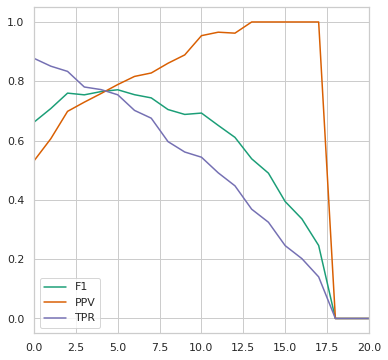

In [129]:
results_550_tr = get_f1_thresholds(y_train, y_pred_proba_train_550lr)
results_550_tr[['F1','PPV','TPR']].plot()
plt.show()

Test set results:


In [86]:
y_pred_proba_test_550lr = model_550lr.predict_proba(X_test)[:, 1]

In [87]:
print(classification_report(y_test, (y_pred_proba_test_550lr > 0.5)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3314
           1       0.60      0.52      0.56        29

    accuracy                           0.99      3343
   macro avg       0.80      0.76      0.78      3343
weighted avg       0.99      0.99      0.99      3343



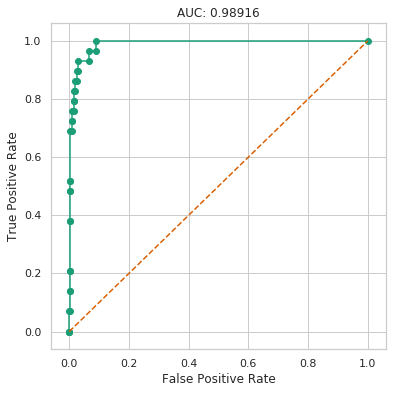

In [128]:
plot_roc_curve(y_test, y_pred_proba_test_550lr)

In [89]:
threshold_f1 = get_best_threshold_for_F1(y_test, y_pred_proba_test_550lr)
f1 = f1_score(y_test, (y_pred_proba_test_550lr > threshold_f1))
print('Max F1 score: {:.4f} for threshold: {:.4f}'.format(f1, threshold_f1))

Max F1 score: 0.6667 for threshold: 0.4148


In [90]:
threshold_precision = get_best_threshold_for_precision(y_test, y_pred_proba_test_550lr)
precision = precision_score(y_test, (y_pred_proba_test_550lr > threshold_precision))
print('Max precision score: {:.4f} for threshold: {:.4f}'.format(precision, threshold_precision))

Max precision score: 0.6875 for threshold: 0.8537


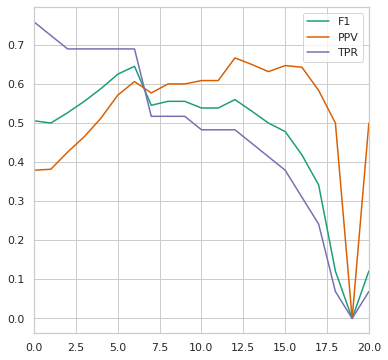

In [127]:
results_550lr_te = get_f1_thresholds(y_test, y_pred_proba_test_550lr)
results_550lr_te[['F1','PPV','TPR']].plot()
plt.show()

In [92]:
results_550lr_te

,threshold,F1,PPV,TPR
0,0.1000,0.505747,0.379310,0.758621
1,0.1500,0.500000,0.381818,0.724138
2,0.2000,0.526316,0.425532,0.689655
3,0.2500,0.555556,0.465116,0.689655
4,0.3000,0.588235,0.512821,0.689655
5,0.3500,0.625000,0.571429,0.689655
6,0.4000,0.645161,0.606061,0.689655
7,0.4500,0.545455,0.576923,0.517241
8,0.5000,0.555556,0.600000,0.517241
9,0.5500,0.555556,0.600000,0.517241


#### Logistic Regression with class weights

In [93]:
imbalance_ratio = len(np.where(y_train == 0)[0]) / len(np.where(y_train == 1)[0])

In [94]:
model_550lrw = LogisticRegression(class_weight={0: 1, 1: imbalance_ratio})
model_550lrw.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight={0: 1, 1: 116.29824561403508},
                   dual=False, fit_intercept=True, intercept_scaling=1,
                   l1_ratio=None, max_iter=100, multi_class='warn', n_jobs=None,
                   penalty='l2', random_state=None, solver='warn', tol=0.0001,
                   verbose=0, warm_start=False)

Train set results:

In [95]:
y_pred_proba_train_550lrw = model_550lrw.predict_proba(X_train)[:, 1]

In [96]:
print(classification_report(y_train, (y_pred_proba_train_550lrw > 0.5)))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     13258
           1       0.25      0.98      0.40       114

    accuracy                           0.98     13372
   macro avg       0.63      0.98      0.70     13372
weighted avg       0.99      0.98      0.98     13372



In [97]:
threshold_f1 = get_best_threshold_for_F1(y_train, y_pred_proba_train_550lrw)
f1 = f1_score(y_train, (y_pred_proba_train_550lrw > threshold_f1))
print('Max F1 score: {:.4f} for threshold: {:.4f}'.format(f1, threshold_f1))

Max F1 score: 0.7184 for threshold: 0.9679


In [98]:
threshold_precision = get_best_threshold_for_precision(y_train, y_pred_proba_train_550lrw)
precision = precision_score(y_train, (y_pred_proba_train_550lrw > threshold_precision))
print('Max precision score: {:.4f} for threshold: {:.4f}'.format(precision, threshold_precision))

Max precision score: 0.7200 for threshold: 0.9980


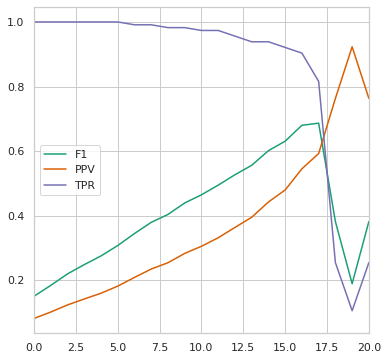

In [126]:
results_550lrw_te = get_f1_thresholds(y_train, y_pred_proba_train_550lrw)
results_550lrw_te[['F1','PPV','TPR']].plot()
plt.show()

Test set results:

In [101]:
y_pred_proba_test_550lrw = model_550lrw.predict_proba(X_test)[:, 1]

In [102]:
print(classification_report(y_test, (y_pred_proba_test_550lrw > 0.5)))

              precision    recall  f1-score   support

           0       1.00      0.97      0.98      3314
           1       0.17      0.76      0.28        29

    accuracy                           0.97      3343
   macro avg       0.59      0.86      0.63      3343
weighted avg       0.99      0.97      0.98      3343



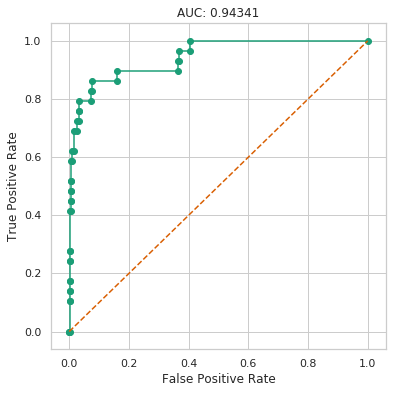

In [125]:
plot_roc_curve(y_test, y_pred_proba_test_550lrw)

In [104]:
threshold_f1 = get_best_threshold_for_F1(y_test, y_pred_proba_test_550lrw)
f1 = f1_score(y_test, (y_pred_proba_test_550lrw > threshold_f1))
print('Test set F1 score: {:.4f} for threshold: {:.4f}'.format(f1, threshold_f1))

Test set F1 score: 0.4800 for threshold: 0.9699


In [105]:
threshold_precision = get_best_threshold_for_precision(y_test, y_pred_proba_test_550lrw)
precision = precision_score(y_test, (y_pred_proba_test_550lrw > threshold_precision))
print('Test set precision score: {:.4f} for threshold: {:.4f}'.format(precision, threshold_precision))

Test set precision score: 0.4483 for threshold: 0.9960


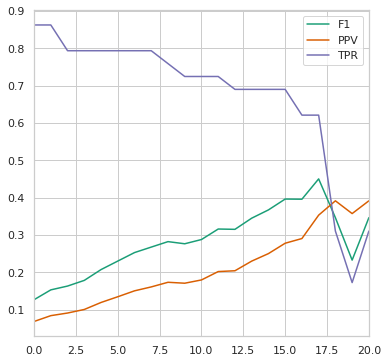

In [124]:
results_550lrw_te = get_f1_thresholds(y_test, y_pred_proba_test_550lrw)
results_550lrw_te[['F1','PPV','TPR']].plot()

In [107]:
results_550lrw_te

,threshold,F1,PPV,TPR
0,0.1000,0.126582,0.068306,0.862069
1,0.1500,0.152905,0.083893,0.862069
2,0.2000,0.163121,0.090909,0.793103
3,0.2500,0.178295,0.100437,0.793103
4,0.3000,0.207207,0.119171,0.793103
5,0.3500,0.230000,0.134503,0.793103
6,0.4000,0.252747,0.150327,0.793103
7,0.4500,0.267442,0.160839,0.793103
8,0.5000,0.282051,0.173228,0.758621
9,0.5500,0.276316,0.170732,0.724138


#### Logistic Regression with Lasso regularization


In [108]:
model_550lrl = LogisticRegression(penalty='l1')
model_550lrl.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

Train set results:


In [109]:
y_pred_proba_train_550lrl = model_550lrl.predict_proba(X_train)[:, 1]

In [110]:
print(classification_report(y_train, (y_pred_proba_train_550lrl > 0.5)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     13258
           1       0.84      0.57      0.68       114

    accuracy                           1.00     13372
   macro avg       0.92      0.78      0.84     13372
weighted avg       1.00      1.00      0.99     13372



Next, we can find optimal threshold maximizing F1 score.

In [111]:
threshold_f1 = get_best_threshold_for_F1(y_train, y_pred_proba_train_550lrl)
f1 = f1_score(y_train, (y_pred_proba_train_550lrl > threshold_f1))
print('Max F1 score: {:.4f} for threshold: {:.4f}'.format(f1, threshold_f1))

Max F1 score: 0.7311 for threshold: 0.2305


In [112]:
threshold_precision = get_best_threshold_for_precision(y_train, y_pred_proba_train_550lrl)
precision = precision_score(y_train, (y_pred_proba_train_550lrl > threshold_precision))
print('Max precision score: {:.4f} for threshold: {:.4f}'.format(precision, threshold_precision))

Max precision score: 1.0000 for threshold: 0.7996


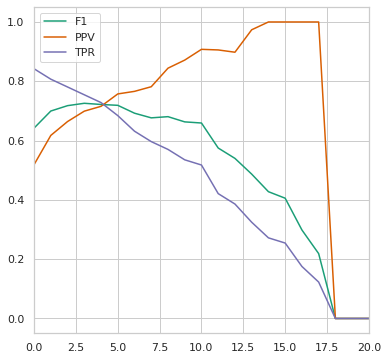

In [123]:
results_550lrl_tr = get_f1_thresholds(y_train, y_pred_proba_train_550lrl)
results_550lrl_tr[['F1','PPV','TPR']].plot()

Test set results:


In [114]:
y_pred_proba_test_550lrl = model_550lrl.predict_proba(X_test)[:, 1]

In [115]:
print(classification_report(y_test, (y_pred_proba_test_550lrl > 0.5)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3314
           1       0.76      0.55      0.64        29

    accuracy                           0.99      3343
   macro avg       0.88      0.78      0.82      3343
weighted avg       0.99      0.99      0.99      3343



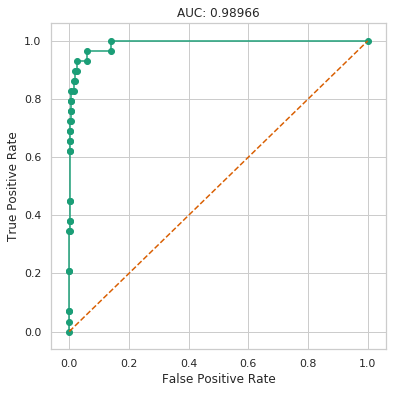

In [122]:
plot_roc_curve(y_test, y_pred_proba_test_550lrl)

In [199]:
threshold_f1 = get_best_threshold_for_F1(y_test, y_pred_proba_test_550lrl)
f1 = f1_score(y_test, (y_pred_proba_test_550lrl > threshold_f1))
print('Max F1 score: {:.4f} for threshold: {:.4f}'.format(f1, threshold_f1))

Max F1 score: 0.6923 for threshold: 0.4529


In [117]:
threshold_precision = get_best_threshold_for_precision(y_test, y_pred_proba_test_550lrl)
precision = precision_score(y_test, (y_pred_proba_test_550lrl > threshold_precision))
print('Max precision score: {:.4f} for threshold: {:.4f}'.format(precision, threshold_precision))

Max precision score: 1.0000 for threshold: 0.9980


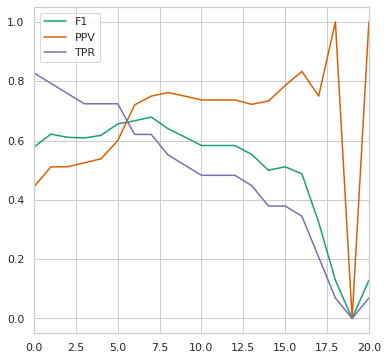

In [121]:
results_550lrl_te = get_f1_thresholds(y_test, y_pred_proba_test_550lrl)
results_550lrl_te[['F1','PPV','TPR']].plot()
plt.show()

In [201]:
results_550lrl_te

,threshold,F1,PPV,TPR
0,0.1000,0.578313,0.444444,0.827586
1,0.1500,0.621622,0.511111,0.793103
2,0.2000,0.611111,0.511628,0.758621
3,0.2500,0.608696,0.525000,0.724138
4,0.3000,0.617647,0.538462,0.724138
5,0.3500,0.656250,0.600000,0.724138
6,0.4000,0.666667,0.720000,0.620690
7,0.4500,0.679245,0.750000,0.620690
8,0.5000,0.640000,0.761905,0.551724
9,0.5500,0.612245,0.750000,0.517241


In [230]:
linear_importances2 = model_550lrl.coef_.ravel()

In [231]:
(linear_importances2 != 0).astype(int).sum()

188

In [232]:
np.where(linear_importances2 != 0)[0]

array([  8,  10,  12,  19,  22,  36,  41,  42,  46,  49,  50,  54,  57,
        64,  67,  68,  75,  77,  78,  82,  83,  98, 102, 108, 112, 113,
       114, 115, 116, 119, 121, 127, 133, 134, 137, 139, 140, 143, 146,
       152, 154, 155, 156, 157, 164, 166, 167, 168, 169, 170, 171, 174,
       179, 187, 188, 190, 191, 193, 194, 196, 202, 203, 213, 214, 215,
       220, 222, 223, 226, 227, 236, 243, 247, 251, 253, 255, 256, 259,
       262, 263, 264, 265, 266, 267, 276, 282, 285, 286, 290, 291, 292,
       293, 294, 296, 299, 301, 303, 307, 308, 309, 311, 314, 322, 323,
       324, 326, 327, 329, 330, 331, 333, 335, 336, 337, 339, 347, 349,
       353, 360, 362, 368, 369, 370, 371, 372, 374, 381, 382, 383, 396,
       404, 405, 409, 413, 427, 429, 431, 432, 433, 434, 435, 436, 437,
       439, 440, 441, 442, 443, 446, 447, 448, 450, 461, 467, 468, 471,
       473, 475, 482, 489, 490, 491, 492, 493, 499, 501, 503, 505, 506,
       511, 512, 513, 514, 517, 519, 521, 522, 527, 537, 538, 54

#### SVM with default settings

In [139]:
model_svm550 = SVC(kernel='rbf', probability=True)
model_svm550.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=True, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

Train set results:

In [140]:
y_pred_proba_train_svm550 = model_svm550.predict_proba(X_train)[:, 1]

In [141]:
print(classification_report(y_train, (y_pred_proba_train_svm550 > 0.5)))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00     13258
           1       0.83      0.34      0.48       114

    accuracy                           0.99     13372
   macro avg       0.91      0.67      0.74     13372
weighted avg       0.99      0.99      0.99     13372



In [142]:
threshold_f1 = get_best_threshold_for_F1(y_train, y_pred_proba_train_svm550)
f1 = f1_score(y_train, (y_pred_proba_train_svm550 > threshold_f1))
print('Max F1 score: {:.4f} for threshold: {:.4f}'.format(f1, threshold_f1))

Max F1 score: 0.7843 for threshold: 0.0080


In [143]:
threshold_precision = get_best_threshold_for_precision(y_train, y_pred_proba_train_svm550)
precision = precision_score(y_train, (y_pred_proba_train_svm550 > threshold_precision))
print('Max precision score: {:.4f} for threshold: {:.4f}'.format(precision, threshold_precision))

Max precision score: 1.0000 for threshold: 0.9800


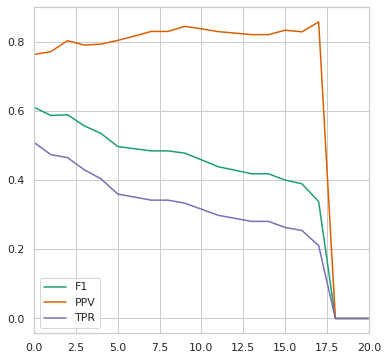

In [144]:
results_svm550_tr = get_f1_thresholds(y_train, y_pred_proba_train_svm550)
results_svm550_tr[['F1','PPV','TPR']].plot()
plt.show()

Test set results:

In [145]:
y_pred_proba_test_svm550 = model_svm550.predict_proba(X_test)[:, 1]

In [146]:
print(classification_report(y_test, (y_pred_proba_test_svm550 > 0.5)))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      3314
           1       0.43      0.21      0.28        29

    accuracy                           0.99      3343
   macro avg       0.71      0.60      0.64      3343
weighted avg       0.99      0.99      0.99      3343



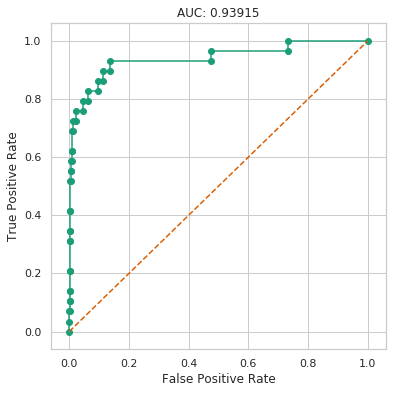

In [147]:
plot_roc_curve(y_test, y_pred_proba_test_svm550)

In [148]:
threshold_f1 = get_best_threshold_for_F1(y_test, y_pred_proba_test_svm550)
f1 = f1_score(y_test, (y_pred_proba_test_svm550 > threshold_f1))
print('Test set F1 score: {:.4f} for threshold: {:.4f}'.format(f1, threshold_f1))

Test set F1 score: 0.5357 for threshold: 0.0701


In [150]:
threshold_precision = get_best_threshold_for_precision(y_test, y_pred_proba_test_svm550)
precision = precision_score(y_test, (y_pred_proba_test_svm550 > threshold_precision))
print('Test set precision score: {:.4f} for threshold: {:.4f}'.format(precision, threshold_precision))

Test set precision score: 1.0000 for threshold: 0.9840


In [151]:
results_svm550_te = get_f1_thresholds(y_test, y_pred_proba_test_svm550)

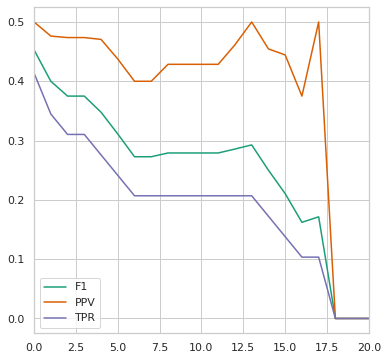

In [152]:
results_svm550_te[['F1','PPV','TPR']].plot()
plt.show()

In [153]:
results_svm550_te

,threshold,F1,PPV,TPR
0,0.1000,0.452830,0.500000,0.413793
1,0.1500,0.400000,0.476190,0.344828
2,0.2000,0.375000,0.473684,0.310345
3,0.2500,0.375000,0.473684,0.310345
4,0.3000,0.347826,0.470588,0.275862
5,0.3500,0.311111,0.437500,0.241379
6,0.4000,0.272727,0.400000,0.206897
7,0.4500,0.272727,0.400000,0.206897
8,0.5000,0.279070,0.428571,0.206897
9,0.5500,0.279070,0.428571,0.206897


#### Linear SVM

In [154]:
model_svm2550 = LinearSVC(penalty='l1', dual=False)
model_svm2550.fit(X_train, y_train)

LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l1', random_state=None, tol=0.0001,
          verbose=0)

Train set results:

In [155]:
print(classification_report(y_train, model_svm2550.predict(X_train)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     13258
           1       0.87      0.67      0.76       114

    accuracy                           1.00     13372
   macro avg       0.94      0.83      0.88     13372
weighted avg       1.00      1.00      1.00     13372



In [156]:
f1_score(y_train, model_svm2550.predict(X_train))

0.7562189054726368

In [157]:
precision_score(y_train, model_svm2550.predict(X_train))

0.8735632183908046

Test set results:

In [158]:
print(classification_report(y_test, model_svm2550.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3314
           1       0.57      0.55      0.56        29

    accuracy                           0.99      3343
   macro avg       0.78      0.77      0.78      3343
weighted avg       0.99      0.99      0.99      3343



In [159]:
f1_score(y_test, model_svm2550.predict(X_test))

0.5614035087719299

In [160]:
precision_score(y_test, model_svm2550.predict(X_test))

0.5714285714285714

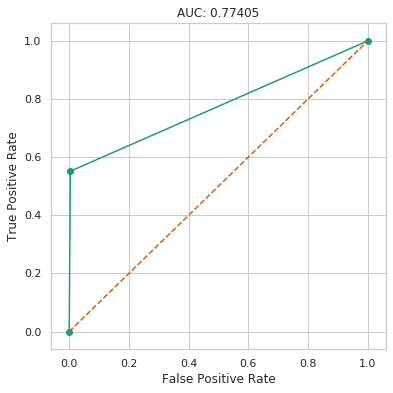

In [161]:
plot_roc_curve(y_test, model_svm2550.predict(X_test))

In [162]:
linear_importances5 = model_svm2550.coef_.ravel()

In [163]:
(linear_importances5 != 0).astype(int).sum()

267

In [164]:
np.where(linear_importances5 != 0)[0]

array([  1,   3,   8,  10,  12,  17,  19,  22,  23,  24,  25,  30,  31,
        35,  36,  40,  41,  42,  44,  47,  50,  54,  57,  61,  63,  64,
        65,  67,  68,  70,  73,  74,  75,  76,  78,  82,  83,  84,  86,
        93,  95,  98, 101, 107, 110, 111, 112, 113, 114, 115, 119, 120,
       121, 123, 124, 125, 126, 127, 133, 136, 137, 139, 140, 142, 144,
       145, 146, 147, 148, 151, 152, 154, 156, 157, 158, 159, 160, 165,
       166, 168, 169, 170, 171, 174, 180, 185, 187, 188, 189, 190, 191,
       192, 193, 194, 196, 200, 202, 207, 213, 215, 220, 222, 223, 226,
       227, 229, 235, 236, 238, 242, 243, 247, 251, 252, 256, 258, 262,
       263, 265, 267, 268, 271, 276, 279, 282, 286, 291, 292, 293, 296,
       299, 301, 302, 303, 307, 308, 309, 311, 313, 314, 316, 317, 322,
       323, 324, 326, 327, 329, 330, 331, 333, 334, 335, 336, 337, 338,
       339, 340, 347, 349, 353, 356, 359, 360, 362, 364, 365, 366, 367,
       368, 370, 371, 372, 374, 375, 377, 381, 382, 383, 384, 38

#### Random Forest with default settings

In [165]:
model_rf550 = RandomForestClassifier(200)
model_rf550.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

Train set results:

In [166]:
y_pred_proba_train_rf550 = model_rf550.predict_proba(X_train)[:, 1]

In [167]:
print(classification_report(y_train, (y_pred_proba_train_rf550 > 0.5)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     13258
           1       1.00      1.00      1.00       114

    accuracy                           1.00     13372
   macro avg       1.00      1.00      1.00     13372
weighted avg       1.00      1.00      1.00     13372



In [168]:
threshold_f1 = get_best_threshold_for_F1(y_train, y_pred_proba_train_rf550)
f1 = f1_score(y_train, (y_pred_proba_train_rf550 > threshold_f1))
print('Max F1 score: {:.4f} for threshold: {:.4f}'.format(f1, threshold_f1))

Max F1 score: 1.0000 for threshold: 0.3206


In [169]:
threshold_precision = get_best_threshold_for_precision(y_train, y_pred_proba_train_rf550)
precision = precision_score(y_train, (y_pred_proba_train_rf550 > threshold_precision))
print('Max precision score: {:.4f} for threshold: {:.4f}'.format(precision, threshold_precision))

Max precision score: 1.0000 for threshold: 0.3206


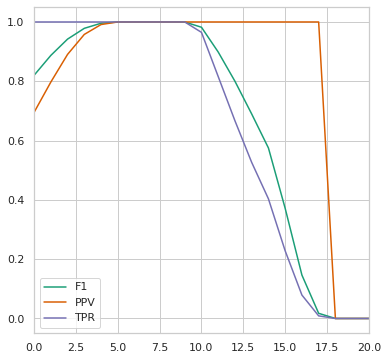

In [170]:
results_rf550_tr = get_f1_thresholds(y_train, y_pred_proba_train_rf550)
results_rf550_tr[['F1','PPV','TPR']].plot()

Test set results:

In [171]:
y_pred_proba_test_rf550 = model_rf550.predict_proba(X_test)[:, 1]

In [172]:
print(classification_report(y_test, (y_pred_proba_test_rf550 > 0.5)))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      3314
           1       0.58      0.38      0.46        29

    accuracy                           0.99      3343
   macro avg       0.79      0.69      0.73      3343
weighted avg       0.99      0.99      0.99      3343



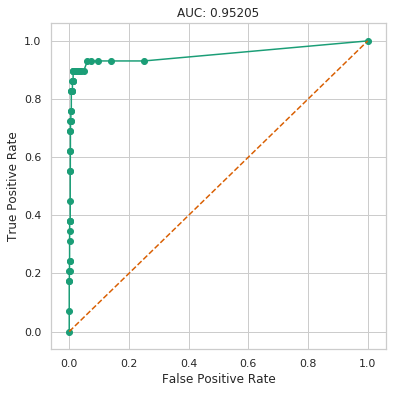

In [173]:
plot_roc_curve(y_test, y_pred_proba_test_rf550)

In [174]:
threshold_f1 = get_best_threshold_for_F1(y_test, y_pred_proba_test_rf550)
f1 = f1_score(y_test, (y_pred_proba_test_rf550 > threshold_f1))
print('Max F1 score: {:.4f} for threshold: {:.4f}'.format(f1, threshold_f1))

Max F1 score: 0.6562 for threshold: 0.3006


In [175]:
threshold_precision = get_best_threshold_for_precision(y_test, y_pred_proba_test_rf550)
precision = precision_score(y_test, (y_pred_proba_test_rf550 > threshold_precision))
print('Max precision score: {:.4f} for threshold: {:.4f}'.format(precision, threshold_precision))

Max precision score: 1.0000 for threshold: 0.7014


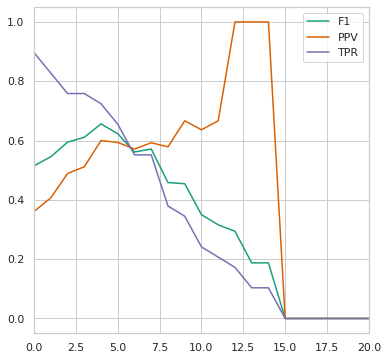

In [177]:
results_rf550_te = get_f1_thresholds(y_test, y_pred_proba_test_rf550)
results_rf550_te[['F1','PPV','TPR']].plot()
plt.show()

In [178]:
results_rf550_te

,threshold,F1,PPV,TPR
0,0.1000,0.514851,0.361111,0.896552
1,0.1500,0.545455,0.406780,0.827586
2,0.2000,0.594595,0.488889,0.758621
3,0.2500,0.611111,0.511628,0.758621
4,0.3000,0.656250,0.600000,0.724138
5,0.3500,0.622951,0.593750,0.655172
6,0.4000,0.561404,0.571429,0.551724
7,0.4500,0.571429,0.592593,0.551724
8,0.5000,0.458333,0.578947,0.379310
9,0.5500,0.454545,0.666667,0.344828


#### 100 features

#### Train/test split

In [179]:
X_train, X_test, y_train, y_test = train_test_split(Xbest100, y, test_size=0.2, stratify=y, random_state=42)

#### Logistic Regression with default settings

In [180]:
model_100lr = LogisticRegression()
model_100lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

Train set results:


In [181]:
y_pred_proba_train_100lr = model_100lr.predict_proba(X_train)[:, 1]

In [182]:
print(classification_report(y_train, (y_pred_proba_train_100lr > 0.5)))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00     13258
           1       0.69      0.38      0.49       114

    accuracy                           0.99     13372
   macro avg       0.84      0.69      0.74     13372
weighted avg       0.99      0.99      0.99     13372



Next, we can find optimal threshold maximizing F1 score.

In [183]:
threshold_f1 = get_best_threshold_for_F1(y_train, y_pred_proba_train_100lr)
f1 = f1_score(y_train, (y_pred_proba_train_100lr > threshold_f1))
print('Max F1 score: {:.4f} for threshold: {:.4f}'.format(f1, threshold_f1))

Max F1 score: 0.6103 for threshold: 0.3567


In [186]:
threshold_precision = get_best_threshold_for_precision(y_train, y_pred_proba_train_100lr)
precision = precision_score(y_train, (y_pred_proba_train_100lr > threshold_precision))
print('Max precision score: {:.4f} for threshold: {:.4f}'.format(precision, threshold_precision))

Max precision score: 1.0000 for threshold: 0.7395


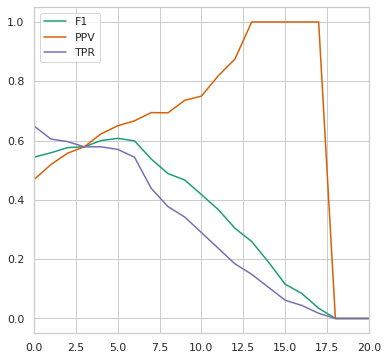

In [187]:
results_100_tr = get_f1_thresholds(y_train, y_pred_proba_train_100lr)
results_100_tr[['F1','PPV','TPR']].plot()
plt.show()

Test set results:


In [188]:
y_pred_proba_test_100lr = model_100lr.predict_proba(X_test)[:, 1]

In [189]:
print(classification_report(y_test, (y_pred_proba_test_100lr > 0.5)))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      3314
           1       0.53      0.31      0.39        29

    accuracy                           0.99      3343
   macro avg       0.76      0.65      0.69      3343
weighted avg       0.99      0.99      0.99      3343



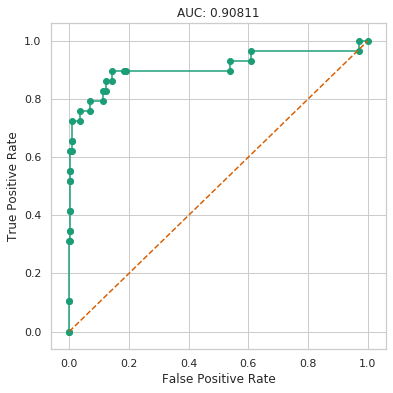

In [190]:
plot_roc_curve(y_test, y_pred_proba_test_100lr)

In [191]:
threshold_f1 = get_best_threshold_for_F1(y_test, y_pred_proba_test_100lr)
f1 = f1_score(y_test, (y_pred_proba_test_100lr > threshold_f1))
print('Max F1 score: {:.4f} for threshold: {:.4f}'.format(f1, threshold_f1))

Max F1 score: 0.5902 for threshold: 0.1804


In [192]:
threshold_precision = get_best_threshold_for_precision(y_test, y_pred_proba_test_100lr)
precision = precision_score(y_test, (y_pred_proba_test_100lr > threshold_precision))
print('Max precision score: {:.4f} for threshold: {:.4f}'.format(precision, threshold_precision))

Max precision score: 0.8182 for threshold: 0.6253


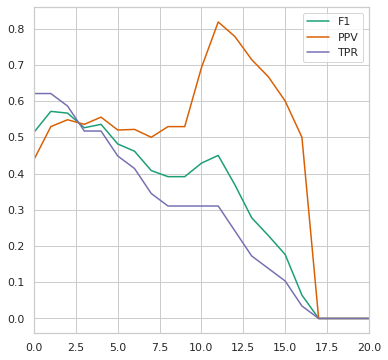

In [194]:
results_100lr_te = get_f1_thresholds(y_test, y_pred_proba_test_100lr)
results_100lr_te[['F1','PPV','TPR']].plot()
plt.show()

In [195]:
results_100lr_te

,threshold,F1,PPV,TPR
0,0.1000,0.514286,0.439024,0.620690
1,0.1500,0.571429,0.529412,0.620690
2,0.2000,0.566667,0.548387,0.586207
3,0.2500,0.526316,0.535714,0.517241
4,0.3000,0.535714,0.555556,0.517241
5,0.3500,0.481481,0.520000,0.448276
6,0.4000,0.461538,0.521739,0.413793
7,0.4500,0.408163,0.500000,0.344828
8,0.5000,0.391304,0.529412,0.310345
9,0.5500,0.391304,0.529412,0.310345


#### Logistic Regression with class weights

In [196]:
imbalance_ratio = len(np.where(y_train == 0)[0]) / len(np.where(y_train == 1)[0])

In [197]:
model_100lrw = LogisticRegression(class_weight={0: 1, 1: imbalance_ratio})
model_100lrw.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight={0: 1, 1: 116.29824561403508},
                   dual=False, fit_intercept=True, intercept_scaling=1,
                   l1_ratio=None, max_iter=100, multi_class='warn', n_jobs=None,
                   penalty='l2', random_state=None, solver='warn', tol=0.0001,
                   verbose=0, warm_start=False)

Train set results:

In [198]:
y_pred_proba_train_100lrw = model_100lrw.predict_proba(X_train)[:, 1]

In [199]:
print(classification_report(y_train, (y_pred_proba_train_100lrw > 0.5)))

              precision    recall  f1-score   support

           0       1.00      0.91      0.95     13258
           1       0.08      0.89      0.15       114

    accuracy                           0.91     13372
   macro avg       0.54      0.90      0.55     13372
weighted avg       0.99      0.91      0.95     13372



In [200]:
threshold_f1 = get_best_threshold_for_F1(y_train, y_pred_proba_train_100lrw)
f1 = f1_score(y_train, (y_pred_proba_train_100lrw > threshold_f1))
print('Max F1 score: {:.4f} for threshold: {:.4f}'.format(f1, threshold_f1))

Max F1 score: 0.5106 for threshold: 0.9559


In [201]:
threshold_precision = get_best_threshold_for_precision(y_train, y_pred_proba_train_100lrw)
precision = precision_score(y_train, (y_pred_proba_train_100lrw > threshold_precision))
print('Max precision score: {:.4f} for threshold: {:.4f}'.format(precision, threshold_precision))

Max precision score: 0.4824 for threshold: 0.9920


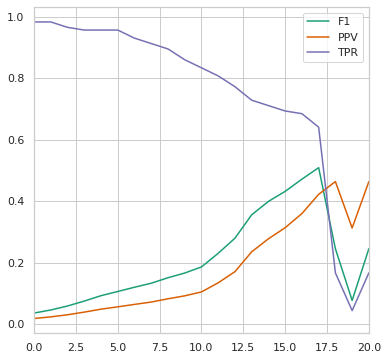

In [202]:
results_100lrw_te = get_f1_thresholds(y_train, y_pred_proba_train_100lrw)
results_100lrw_te[['F1','PPV','TPR']].plot()
plt.show()

Test set results:

In [203]:
y_pred_proba_test_100lrw = model_100lrw.predict_proba(X_test)[:, 1]

In [204]:
print(classification_report(y_test, (y_pred_proba_test_100lrw > 0.5)))

              precision    recall  f1-score   support

           0       1.00      0.91      0.95      3314
           1       0.07      0.83      0.13        29

    accuracy                           0.90      3343
   macro avg       0.53      0.87      0.54      3343
weighted avg       0.99      0.90      0.94      3343



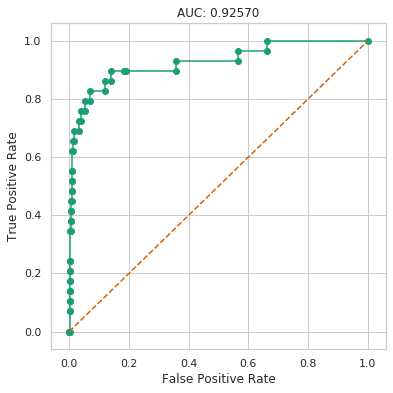

In [205]:
plot_roc_curve(y_test, y_pred_proba_test_100lrw)

In [206]:
threshold_f1 = get_best_threshold_for_F1(y_test, y_pred_proba_test_100lrw)
f1 = f1_score(y_test, (y_pred_proba_test_100lrw > threshold_f1))
print('Test set F1 score: {:.4f} for threshold: {:.4f}'.format(f1, threshold_f1))

Test set F1 score: 0.4557 for threshold: 0.9599


In [207]:
threshold_precision = get_best_threshold_for_precision(y_test, y_pred_proba_test_100lrw)
precision = precision_score(y_test, (y_pred_proba_test_100lrw > threshold_precision))
print('Test set precision score: {:.4f} for threshold: {:.4f}'.format(precision, threshold_precision))

Test set precision score: 0.4762 for threshold: 0.9960


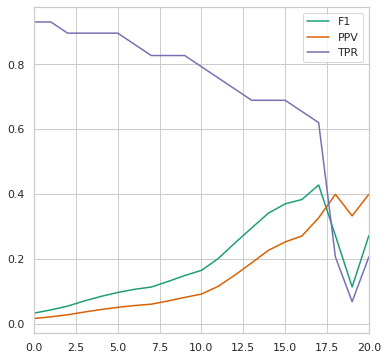

In [208]:
results_100lrw_te = get_f1_thresholds(y_test, y_pred_proba_test_100lrw)
results_100lrw_te[['F1','PPV','TPR']].plot()
plt.show()

In [209]:
results_100lrw_te

,threshold,F1,PPV,TPR
0,0.1000,0.033750,0.017187,0.931034
1,0.1500,0.043513,0.022277,0.931034
2,0.2000,0.055260,0.028509,0.896552
3,0.2500,0.071135,0.037037,0.896552
4,0.3000,0.085246,0.044750,0.896552
5,0.3500,0.097378,0.051485,0.896552
6,0.4000,0.107066,0.057078,0.862069
7,0.4500,0.114014,0.061224,0.827586
8,0.5000,0.131148,0.071217,0.827586
9,0.5500,0.149533,0.082192,0.827586


#### Logistic Regression with Lasso regularization


In [210]:
model_100lrl = LogisticRegression(penalty='l1')
model_100lrl.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

Train set results:


In [211]:
y_pred_proba_train_100lrl = model_100lrl.predict_proba(X_train)[:, 1]

In [212]:
print(classification_report(y_train, (y_pred_proba_train_100lrl > 0.5)))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00     13258
           1       0.71      0.36      0.48       114

    accuracy                           0.99     13372
   macro avg       0.85      0.68      0.74     13372
weighted avg       0.99      0.99      0.99     13372



Next, we can find optimal threshold maximizing F1 score.

In [213]:
threshold_f1 = get_best_threshold_for_F1(y_train, y_pred_proba_train_100lrl)
f1 = f1_score(y_train, (y_pred_proba_train_100lrl > threshold_f1))
print('Max F1 score: {:.4f} for threshold: {:.4f}'.format(f1, threshold_f1))

Max F1 score: 0.6047 for threshold: 0.3267


In [214]:
threshold_precision = get_best_threshold_for_precision(y_train, y_pred_proba_train_100lrl)
precision = precision_score(y_train, (y_pred_proba_train_100lrl > threshold_precision))
print('Max precision score: {:.4f} for threshold: {:.4f}'.format(precision, threshold_precision))

Max precision score: 1.0000 for threshold: 0.8036


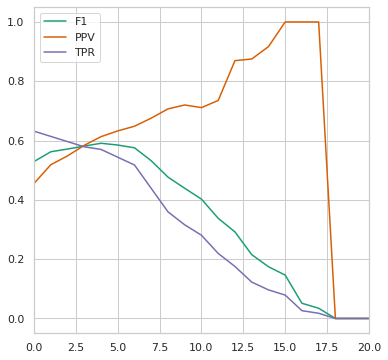

In [216]:
results_100lrl_tr = get_f1_thresholds(y_train, y_pred_proba_train_100lrl)
results_100lrl_tr[['F1','PPV','TPR']].plot()
plt.show()

Test set results:


In [217]:
y_pred_proba_test_100lrl = model_100lrl.predict_proba(X_test)[:, 1]

In [218]:
print(classification_report(y_test, (y_pred_proba_test_100lrl > 0.5)))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      3314
           1       0.55      0.38      0.45        29

    accuracy                           0.99      3343
   macro avg       0.77      0.69      0.72      3343
weighted avg       0.99      0.99      0.99      3343



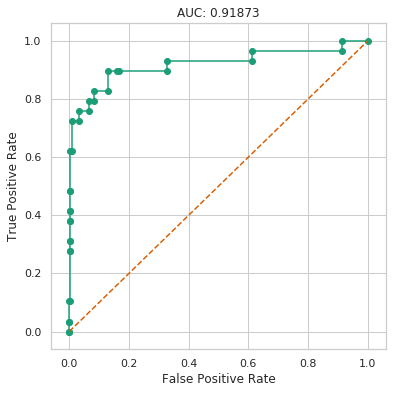

In [219]:
plot_roc_curve(y_test, y_pred_proba_test_100lrl)

In [220]:
threshold_f1 = get_best_threshold_for_F1(y_test, y_pred_proba_test_100lrl)
f1 = f1_score(y_test, (y_pred_proba_test_100lrl > threshold_f1))
print('Max F1 score: {:.4f} for threshold: {:.4f}'.format(f1, threshold_f1))

Max F1 score: 0.6102 for threshold: 0.1764


In [221]:
threshold_precision = get_best_threshold_for_precision(y_test, y_pred_proba_test_100lrl)
precision = precision_score(y_test, (y_pred_proba_test_100lrl > threshold_precision))
print('Max precision score: {:.4f} for threshold: {:.4f}'.format(precision, threshold_precision))

Max precision score: 0.7273 for threshold: 0.6493


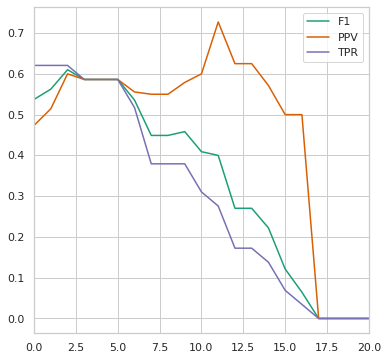

In [222]:
results_100lrl_te = get_f1_thresholds(y_test, y_pred_proba_test_100lrl)
results_100lrl_te[['F1','PPV','TPR']].plot()
plt.show()

In [223]:
results_100lrl_te

,threshold,F1,PPV,TPR
0,0.1000,0.537313,0.473684,0.620690
1,0.1500,0.562500,0.514286,0.620690
2,0.2000,0.610169,0.600000,0.620690
3,0.2500,0.586207,0.586207,0.586207
4,0.3000,0.586207,0.586207,0.586207
5,0.3500,0.586207,0.586207,0.586207
6,0.4000,0.535714,0.555556,0.517241
7,0.4500,0.448980,0.550000,0.379310
8,0.5000,0.448980,0.550000,0.379310
9,0.5500,0.458333,0.578947,0.379310


In [224]:
linear_importances2 = model_100lrl.coef_.ravel()

In [225]:
(linear_importances2 != 0).astype(int).sum()

69

In [226]:
np.where(linear_importances2 != 0)[0]

array([ 0,  1,  2,  3,  5,  6,  7,  8, 10, 13, 14, 16, 17, 19, 20, 22, 23,
       27, 28, 29, 33, 35, 37, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       54, 55, 56, 57, 58, 59, 60, 64, 65, 66, 67, 68, 70, 71, 72, 73, 74,
       75, 76, 77, 79, 80, 83, 84, 85, 86, 88, 89, 90, 91, 93, 95, 96, 97,
       99])

#### SVM with default settings

In [268]:
model_svm100 = SVC(kernel='rbf', probability=True)
model_svm100.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=True, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

Train set results:

In [269]:
y_pred_proba_train_svm100 = model_svm100.predict_proba(X_train)[:, 1]

In [270]:
print(classification_report(y_train, (y_pred_proba_train_svm100 > 0.5)))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00     13258
           1       0.88      0.12      0.22       114

    accuracy                           0.99     13372
   macro avg       0.93      0.56      0.61     13372
weighted avg       0.99      0.99      0.99     13372



In [271]:
threshold_f1 = get_best_threshold_for_F1(y_train, y_pred_proba_train_svm100)
f1 = f1_score(y_train, (y_pred_proba_train_svm100 > threshold_f1))
print('Max F1 score: {:.4f} for threshold: {:.4f}'.format(f1, threshold_f1))

Max F1 score: 0.6425 for threshold: 0.0080


In [272]:
threshold_precision = get_best_threshold_for_precision(y_train, y_pred_proba_train_svm100)
precision = precision_score(y_train, (y_pred_proba_train_svm100 > threshold_precision))
print('Max precision score: {:.4f} for threshold: {:.4f}'.format(precision, threshold_precision))

Max precision score: 1.0000 for threshold: 0.9118


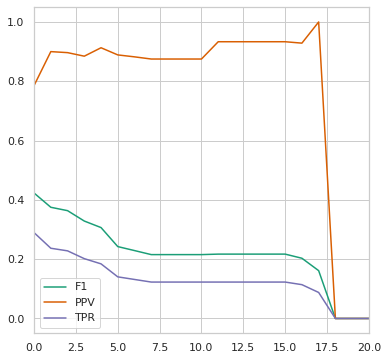

In [273]:
results_svm100_tr = get_f1_thresholds(y_train, y_pred_proba_train_svm100)
results_svm100_tr[['F1','PPV','TPR']].plot()
plt.show()

Test set results:

In [274]:
y_pred_proba_test_svm100 = model_svm100.predict_proba(X_test)[:, 1]

In [275]:
print(classification_report(y_test, (y_pred_proba_test_svm100 > 0.5)))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      3314
           1       0.75      0.10      0.18        29

    accuracy                           0.99      3343
   macro avg       0.87      0.55      0.59      3343
weighted avg       0.99      0.99      0.99      3343



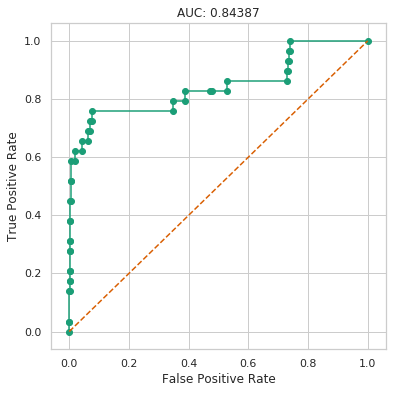

In [276]:
plot_roc_curve(y_test, y_pred_proba_test_svm100)

In [277]:
threshold_f1 = get_best_threshold_for_F1(y_test, y_pred_proba_test_svm100)
f1 = f1_score(y_test, (y_pred_proba_test_svm100 > threshold_f1))
print('Test set F1 score: {:.4f} for threshold: {:.4f}'.format(f1, threshold_f1))

Test set F1 score: 0.5075 for threshold: 0.0100


In [278]:
threshold_precision = get_best_threshold_for_precision(y_test, y_pred_proba_test_svm100)
precision = precision_score(y_test, (y_pred_proba_test_svm100 > threshold_precision))
print('Test set precision score: {:.4f} for threshold: {:.4f}'.format(precision, threshold_precision))

Test set precision score: 1.0000 for threshold: 0.9619


In [279]:
results_svm100_te = get_f1_thresholds(y_test, y_pred_proba_test_svm100)

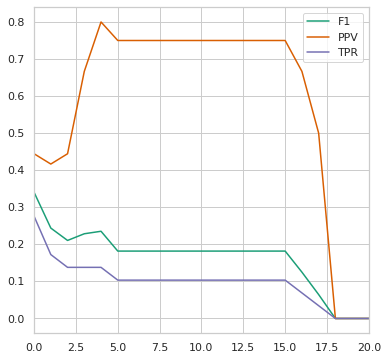

In [280]:
results_svm100_te[['F1','PPV','TPR']].plot()
plt.show()

In [281]:
results_svm100_te

,threshold,F1,PPV,TPR
0,0.1000,0.340426,0.444444,0.275862
1,0.1500,0.243902,0.416667,0.172414
2,0.2000,0.210526,0.444444,0.137931
3,0.2500,0.228571,0.666667,0.137931
4,0.3000,0.235294,0.800000,0.137931
5,0.3500,0.181818,0.750000,0.103448
6,0.4000,0.181818,0.750000,0.103448
7,0.4500,0.181818,0.750000,0.103448
8,0.5000,0.181818,0.750000,0.103448
9,0.5500,0.181818,0.750000,0.103448


#### Linear SVM

In [282]:
from sklearn.svm import LinearSVC

model_svm2100 = LinearSVC(penalty='l1', dual=False)
model_svm2100.fit(X_train, y_train)

LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l1', random_state=None, tol=0.0001,
          verbose=0)

Train set results:

In [283]:
print(classification_report(y_train, model_svm2100.predict(X_train)))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00     13258
           1       0.70      0.35      0.47       114

    accuracy                           0.99     13372
   macro avg       0.85      0.67      0.73     13372
weighted avg       0.99      0.99      0.99     13372



In [284]:
f1_score(y_train, model_svm2100.predict(X_train))

0.4678362573099415

In [285]:
precision_score(y_train, model_svm2100.predict(X_train))

0.7017543859649122

Test set results:

In [286]:
print(classification_report(y_test, model_svm2100.predict(X_test)))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      3314
           1       0.62      0.34      0.44        29

    accuracy                           0.99      3343
   macro avg       0.81      0.67      0.72      3343
weighted avg       0.99      0.99      0.99      3343



In [287]:
f1_score(y_test, model_svm2100.predict(X_test))

0.4444444444444445

In [288]:
precision_score(y_test, model_svm2100.predict(X_test))

0.625

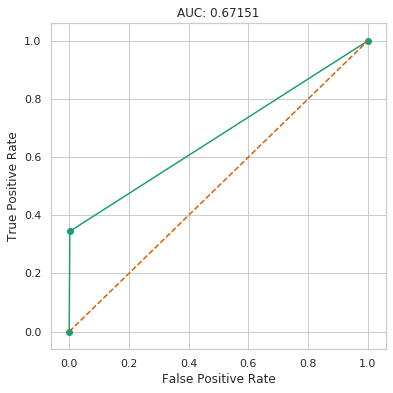

In [289]:
plot_roc_curve(y_test, model_svm2100.predict(X_test))

In [290]:
linear_importances4 = model_svm2100.coef_.ravel()

In [291]:
(linear_importances4 != 0).astype(int).sum()

79

In [292]:
np.where(linear_importances4 != 0)[0]

array([ 0,  1,  2,  3,  4,  6,  7,  8,  9, 10, 13, 14, 16, 17, 19, 20, 22,
       23, 24, 26, 27, 28, 30, 31, 32, 33, 34, 35, 37, 41, 42, 43, 44, 45,
       46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 64,
       65, 66, 67, 68, 69, 70, 71, 72, 74, 75, 77, 79, 80, 82, 83, 84, 86,
       88, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

#### Random Forest with default settings

In [293]:
model_rf100 = RandomForestClassifier(200)
model_rf100.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

Train set results:

In [298]:
y_pred_proba_train_rf100 = model_rf100.predict_proba(X_train)[:, 1]

In [299]:
print(classification_report(y_train, (y_pred_proba_train_rf100 > 0.5)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     13258
           1       1.00      1.00      1.00       114

    accuracy                           1.00     13372
   macro avg       1.00      1.00      1.00     13372
weighted avg       1.00      1.00      1.00     13372



In [300]:
threshold_f1 = get_best_threshold_for_F1(y_train, y_pred_proba_train_rf100)
f1 = f1_score(y_train, (y_pred_proba_train_rf100 > threshold_f1))
print('Max F1 score: {:.4f} for threshold: {:.4f}'.format(f1, threshold_f1))

Max F1 score: 1.0000 for threshold: 0.3066


In [306]:
threshold_precision = get_best_threshold_for_precision(y_train, y_pred_proba_train_rf100)
precision = precision_score(y_train, (y_pred_proba_train_rf100 > threshold_precision))
print('Max precision score: {:.4f} for threshold: {:.4f}'.format(precision, threshold_precision))

Max precision score: 1.0000 for threshold: 0.3066


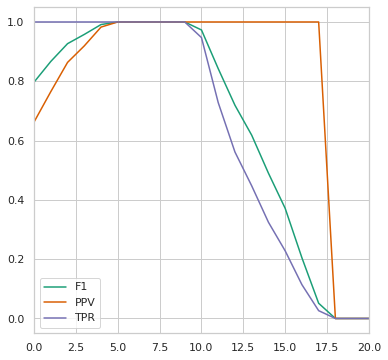

In [301]:
results_rf_tr100 = get_f1_thresholds(y_train, y_pred_proba_train_rf100)
results_rf_tr100[['F1','PPV','TPR']].plot()
plt.show()

Test set results:

In [302]:
y_pred_proba_test_rf100 = model_rf100.predict_proba(X_test)[:, 1]

In [303]:
print(classification_report(y_test, (y_pred_proba_test_rf100 > 0.5)))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      3314
           1       0.53      0.31      0.39        29

    accuracy                           0.99      3343
   macro avg       0.76      0.65      0.69      3343
weighted avg       0.99      0.99      0.99      3343



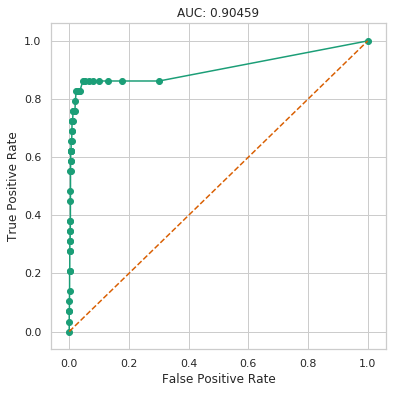

In [304]:
plot_roc_curve(y_test, y_pred_proba_test_rf100)

In [308]:
threshold_f1 = get_best_threshold_for_F1(y_test, y_pred_proba_test_rf100)
f1 = f1_score(y_test, (y_pred_proba_test_rf100 > threshold_f1))
print('Max F1 score: {:.4f} for threshold: {:.4f}'.format(f1, threshold_f1))

Max F1 score: 0.5714 for threshold: 0.2705


In [307]:
threshold_precision = get_best_threshold_for_precision(y_test, y_pred_proba_test_rf100)
precision = precision_score(y_test, (y_pred_proba_test_rf100 > threshold_precision))
print('Max precision score: {:.4f} for threshold: {:.4f}'.format(precision, threshold_precision))

Max precision score: 1.0000 for threshold: 0.8016


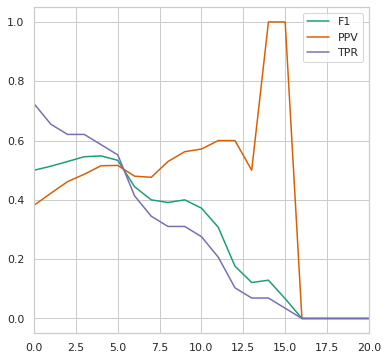

In [309]:
results_rf100_te = get_f1_thresholds(y_test, y_pred_proba_test_rf100)
results_rf100_te[['F1','PPV','TPR']].plot()

In [310]:
results_rf100_te

,threshold,F1,PPV,TPR
0,0.1000,0.500000,0.381818,0.724138
1,0.1500,0.513514,0.422222,0.655172
2,0.2000,0.529412,0.461538,0.620690
3,0.2500,0.545455,0.486486,0.620690
4,0.3000,0.548387,0.515152,0.586207
5,0.3500,0.533333,0.516129,0.551724
6,0.4000,0.444444,0.480000,0.413793
7,0.4500,0.400000,0.476190,0.344828
8,0.5000,0.391304,0.529412,0.310345
9,0.5500,0.400000,0.562500,0.310345


Logistic Regression models are performing better on dataset with 550 than 100 features but SVM and Random Forest seem to be overfitted on larger set. 

### Recursive Feature Elimination

#### RFE with LogisticRegression

In [465]:
for i in [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300]: 
    X_sub = RFE(LogisticRegression(), i, step=100, verbose=1).fit_transform(Xbest550, y)
    X_train, X_test, y_train, y_test = train_test_split(X_sub, y, test_size=0.2, stratify=y, random_state=42)
    model_lrsub = LogisticRegression()
    model_lrsub.fit(X_train, y_train)
    y_pred_proba_train_lrsub = model_lrsub.predict_proba(X_train)[:, 1]
    y_pred_proba_test_lrsub = model_lrsub.predict_proba(X_test)[:, 1]
    threshold_f1 = get_best_threshold_for_F1(y_train, y_pred_proba_train_lrsub)
    f1 = f1_score(y_train, (y_pred_proba_train_lrsub > threshold_f1))
    print(str(i))
    print('Max F1 score: {:.4f} for threshold: {:.4f}'.format(f1, threshold_f1))
    threshold_f1 = get_best_threshold_for_F1(y_test, y_pred_proba_test_lrsub)
    f1 = f1_score(y_test, (y_pred_proba_test_lrsub > threshold_f1))
    print('Max F1 score: {:.4f} for threshold: {:.4f}'.format(f1, threshold_f1))

Fitting estimator with 550 features.
Fitting estimator with 450 features.
Fitting estimator with 350 features.
Fitting estimator with 250 features.
Fitting estimator with 150 features.
100
Max F1 score: 0.6988 for threshold: 0.1864
Max F1 score: 0.7813 for threshold: 0.3387
Fitting estimator with 550 features.
Fitting estimator with 450 features.
Fitting estimator with 350 features.
Fitting estimator with 250 features.
Fitting estimator with 150 features.
110
Max F1 score: 0.7031 for threshold: 0.1703
Max F1 score: 0.7813 for threshold: 0.2705
Fitting estimator with 550 features.
Fitting estimator with 450 features.
Fitting estimator with 350 features.
Fitting estimator with 250 features.
Fitting estimator with 150 features.
120
Max F1 score: 0.7034 for threshold: 0.2445
Max F1 score: 0.8000 for threshold: 0.3948
Fitting estimator with 550 features.
Fitting estimator with 450 features.
Fitting estimator with 350 features.
Fitting estimator with 250 features.
Fitting estimator with 150 

#### RFE with DecisionTreeClassifier

In [461]:
for i in [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]: 
    X_sub = RFE(DecisionTreeClassifier(), i, step=100, verbose=1).fit_transform(Xbest550, y)
    X_train, X_test, y_train, y_test = train_test_split(X_sub, y, test_size=0.2, stratify=y, random_state=42)
    model_dtsub = DecisionTreeClassifier()
    model_dtsub.fit(X_train, y_train)
    y_pred_proba_train_dtsub = model_dtsub.predict_proba(X_train)[:, 1]
    y_pred_proba_test_dtsub = model_dtsub.predict_proba(X_test)[:, 1]
    threshold_f1 = get_best_threshold_for_F1(y_train, y_pred_proba_train_dtsub)
    f1 = f1_score(y_train, (y_pred_proba_train_dtsub > threshold_f1))
    print(str(i))
    print('Max F1 score: {:.4f} for threshold: {:.4f}'.format(f1, threshold_f1))
    threshold_f1 = get_best_threshold_for_F1(y_test, y_pred_proba_test_dtsub)
    f1 = f1_score(y_test, (y_pred_proba_test_dtsub > threshold_f1))
    print('Max F1 score: {:.4f} for threshold: {:.4f}'.format(f1, threshold_f1))

Fitting estimator with 550 features.
Fitting estimator with 450 features.
Fitting estimator with 350 features.
Fitting estimator with 250 features.
Fitting estimator with 150 features.
Fitting estimator with 50 features.
10
Max F1 score: 1.0000 for threshold: 0.0000
Max F1 score: 0.4545 for threshold: 0.0000
Fitting estimator with 550 features.
Fitting estimator with 450 features.
Fitting estimator with 350 features.
Fitting estimator with 250 features.
Fitting estimator with 150 features.
Fitting estimator with 50 features.
20
Max F1 score: 1.0000 for threshold: 0.0000
Max F1 score: 0.4507 for threshold: 0.0000
Fitting estimator with 550 features.
Fitting estimator with 450 features.
Fitting estimator with 350 features.
Fitting estimator with 250 features.
Fitting estimator with 150 features.
Fitting estimator with 50 features.
30
Max F1 score: 1.0000 for threshold: 0.0000
Max F1 score: 0.4194 for threshold: 0.0000
Fitting estimator with 550 features.
Fitting estimator with 450 featur

#### RFE with RandomForestClassifier

In [466]:
for i in [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200]: 
    X_sub = RFE(RandomForestClassifier(200), i, step=100, verbose=1).fit_transform(Xbest550, y)
    X_train, X_test, y_train, y_test = train_test_split(X_sub, y, test_size=0.2, stratify=y, random_state=42)
    model_rfsub = RandomForestClassifier(200)
    model_rfsub.fit(X_train, y_train)
    y_pred_proba_train_rfsub = model_rfsub.predict_proba(X_train)[:, 1]
    y_pred_proba_test_rfsub = model_rfsub.predict_proba(X_test)[:, 1]
    threshold_f1 = get_best_threshold_for_F1(y_train, y_pred_proba_train_rfsub)
    f1 = f1_score(y_train, (y_pred_proba_train_rfsub > threshold_f1))
    print(str(i))
    print('Max F1 score: {:.4f} for threshold: {:.4f}'.format(f1, threshold_f1))
    threshold_f1 = get_best_threshold_for_F1(y_test, y_pred_proba_test_rfsub)
    f1 = f1_score(y_test, (y_pred_proba_test_rfsub > threshold_f1))
    print('Max F1 score: {:.4f} for threshold: {:.4f}'.format(f1, threshold_f1))

Fitting estimator with 550 features.
Fitting estimator with 450 features.
Fitting estimator with 350 features.
Fitting estimator with 250 features.
Fitting estimator with 150 features.
Fitting estimator with 50 features.
10
Max F1 score: 1.0000 for threshold: 0.3868
Max F1 score: 0.5455 for threshold: 0.1904
Fitting estimator with 550 features.
Fitting estimator with 450 features.
Fitting estimator with 350 features.
Fitting estimator with 250 features.
Fitting estimator with 150 features.
Fitting estimator with 50 features.
20
Max F1 score: 1.0000 for threshold: 0.3707
Max F1 score: 0.5714 for threshold: 0.1964
Fitting estimator with 550 features.
Fitting estimator with 450 features.
Fitting estimator with 350 features.
Fitting estimator with 250 features.


KeyboardInterrupt: 

DecisionTree and RadomForest models seem to be overtfitted even with only 10 features.
Best 150 features was obtained with Logistic Regression RFE.

#### Best 150  feature selection obtained by RFE

In [311]:
X_sub = RFE(LogisticRegression(), 150, step=100, verbose=1).fit_transform(Xbest550, y)

Fitting estimator with 550 features.
Fitting estimator with 450 features.
Fitting estimator with 350 features.
Fitting estimator with 250 features.


### Random forest features importance selection

In [367]:
model_rf = RandomForestClassifier(200)

In [368]:
fi = model_rf.fit(Xbest550, y).feature_importances_

In [369]:
(fi > 0).astype(int).sum()

550

In [437]:
len(np.where(fi > 0.002)[0])

144

In [436]:
np.where(fi > 0.002)[0]

array([  4,  11,  12,  13,  15,  20,  21,  24,  25,  28,  30,  31,  35,
        36,  39,  44,  54,  62,  65,  67,  68,  71,  72,  82, 102, 109,
       112, 114, 115, 116, 118, 122, 124, 125, 130, 132, 133, 138, 139,
       140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 154, 155, 164,
       165, 166, 167, 169, 170, 173, 174, 179, 187, 190, 196, 226, 227,
       232, 235, 236, 239, 240, 241, 251, 256, 258, 260, 261, 263, 264,
       265, 266, 291, 298, 299, 302, 305, 311, 323, 329, 331, 332, 333,
       345, 346, 353, 354, 360, 361, 365, 371, 372, 373, 379, 380, 381,
       382, 384, 385, 399, 403, 404, 405, 406, 407, 408, 410, 411, 415,
       417, 418, 420, 423, 426, 427, 431, 437, 441, 442, 444, 445, 447,
       448, 463, 464, 475, 477, 503, 504, 507, 511, 527, 537, 539, 543,
       546])

In [429]:
rfbest = list(np.where(fi > 0.002)[0])

#### Best 144 feature selection obtained by Random forest features importance selection


In [431]:
Xrfbest = Xbest550.iloc[:, rfbest]

### Exploring models with weighting classes techniques.

In [336]:
models = [
    [('LogReg', LogisticRegression())],
    [('RanFor', RandomForestClassifier())],
    [('SVM', SVC())]  
]

params_grid = [
     {'LogReg__C': [0.001, 0.01, 0.1, 1, 10, 100], 
     'LogReg__penalty': ['l1', 'l2'],
     'LogReg__class_weight': [{0: 1, 1: 1}, {0: 1, 1: 40}, {0: 1, 1: 60}, {0: 1, 1: 80}]
    },
     {'RanFor__n_estimators': [50], 
      'RanFor__max_features': [None],
      'RanFor__max_depth': [5, 10, 20, 40],
      'RanFor__min_samples_leaf': [5, 15, 20, 40],
      'RanFor__min_samples_split': [5, 15, 20, 40],
      'RanFor__class_weight': [{0: 1, 1: 1}, {0: 1, 1: 40}, {0: 1, 1: 60}, {0: 1, 1: 80}]
     },
    
     {'SVM__kernel': ['rbf'], 
      'SVM__gamma': [1e-3, 1e-4],
      'SVM__C': [1, 10, 100, 1000],
      'SVM__class_weight': [{0: 1, 1: 1}, {0: 1, 1: 40}, {0: 1, 1: 60}, {0: 1, 1: 80}]
     },    
    
     {'SVM__kernel': ['linear'], 
            'SVM__C': [1, 10, 100, 1000],
      'SVM__class_weight': [{0: 1, 1: 1}, {0: 1, 1: 40}, {0: 1, 1: 60}, {0: 1, 1: 80}]
     }
]

In [360]:
def f1_score_with_best_threshold(y_true, y_pred_proba):
    optimal_threshold = get_best_threshold_for_F1(y_true, y_pred_proba)
    f1 = f1_score(y_true, (y_pred_proba > optimal_threshold))
    return f1

### GridSearchCV for model with 150 features selected by RFE with LogisticRegression

#### Train/test split

In [443]:
X_train, X_test, y_train, y_test = train_test_split(X_sub, y, test_size=0.2, stratify=y, random_state=42)

In [466]:
models = [
    [('LogReg', LogisticRegression())],
    [('SVM', SVC(probability=True))]  
]

params_grid = [
     {'LogReg__C': [0.01, 0.1, 1, 10], 
     'LogReg__penalty': ['l1', 'l2'],
     'LogReg__class_weight': [{0: 1, 1: 1}, {0: 1, 1: 50}, {0: 1, 1: 100}]
    },
    
     {'SVM__kernel': ['linear'], 
            'SVM__C': [1, 10, 100],
      'SVM__class_weight': [{0: 1, 1: 1}, {0: 1, 1: 50}, {0: 1, 1: 100}]
     }
]

In [501]:
best_models = []
best_results = []
for pipe, params in zip(models, params_grid):
    pipeline = Pipeline(pipe)
    
    gs = GridSearchCV(estimator=pipeline,
                      param_grid=params,
                      cv=StratifiedKFold(3),
                      scoring=make_scorer(f1_score_with_best_threshold, needs_proba=True),
                      verbose=1, n_jobs=-1)
    
    gs.fit(X_train, y_train)
    best_models.append(gs.best_estimator_)
    results = gs.cv_results_
    y_pred_proba = gs.best_estimator_.predict_proba(X_test)[:, 1]
    best_threshold = get_best_threshold_for_F1(y_test, y_pred_proba, thresholds_number=1000)

    results['test_set_F1'] = f1_score(y_test, (y_pred_proba>best_threshold))
    best_results.append(pd.DataFrame(results))

Fitting 3 folds for each of 192 candidates, totalling 576 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


KeyboardInterrupt: 

In [471]:
best_models[0]

Pipeline(memory=None,
         steps=[('LogReg',
                 LogisticRegression(C=1, class_weight={0: 1, 1: 1}, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='warn', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='warn', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [451]:
best_models[0][0].get_params()

{'C': 1,
 'class_weight': {0: 1, 1: 1},
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'warn',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'warn',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [497]:
best_models[1]

SVC(C=1, cache_size=200, class_weight={0: 1, 1: 1}, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=True, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [470]:
best_models[1][0].get_params()

{'C': 1,
 'cache_size': 200,
 'class_weight': {0: 1, 1: 1},
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'auto_deprecated',
 'kernel': 'linear',
 'max_iter': -1,
 'probability': True,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

### GridSearchCV for model with 144 features selected through Random forest features importances

#### Train/test split

In [498]:
X_train, X_test, y_train, y_test = train_test_split(Xrfbest, y, test_size=0.2, stratify=y, random_state=42)

In [504]:
models = [
    [('RanFor', RandomForestClassifier())],
    [('SVM', SVC(probability=True))]  
]

params_grid = [
     
     {'RanFor__n_estimators': [50], 
      
      
      'RanFor__min_samples_leaf': [15, 20, 40],
      'RanFor__min_samples_split': [15, 20, 40],
      'RanFor__class_weight': [{0: 1, 1: 1}, {0: 1, 1: 50}, {0: 1, 1: 100}]
     },
    
     {'SVM__kernel': ['rbf'], 
      'SVM__gamma': [1e-3, 1e-4],
      'SVM__C': [1, 10, 100],
      'SVM__class_weight': [{0: 1, 1: 1}, {0: 1, 1: 50}, {0: 1, 1: 100}]
     }
]

In [505]:
best_models1 = []
best_results1 = []
for pipe, params in zip(models, params_grid):
    pipeline = Pipeline(pipe)
    
    gs = GridSearchCV(estimator=pipeline,
                      param_grid=params,
                      cv=StratifiedKFold(3),
                      scoring=make_scorer(f1_score_with_best_threshold, needs_proba=True),
                      verbose=1, n_jobs=-1)
    
    gs.fit(X_train, y_train)
    best_models1.append(gs.best_estimator_)
    results = gs.cv_results_
    y_pred_proba = gs.best_estimator_.predict_proba(X_test)[:, 1]
    best_threshold = get_best_threshold_for_F1(y_test, y_pred_proba, thresholds_number=1000)

    results['test_set_F1'] = f1_score(y_test, (y_pred_proba>best_threshold))
    best_results1.append(pd.DataFrame(results))

Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:  2.6min finished


Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  9.2min
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed: 11.0min finished


In [510]:
best_models1[0]

Pipeline(memory=None,
         steps=[('RanFor',
                 RandomForestClassifier(bootstrap=True,
                                        class_weight={0: 1, 1: 50},
                                        criterion='gini', max_depth=None,
                                        max_features='auto',
                                        max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=15,
                                        min_samples_split=15,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=50, n_jobs=None,
                                        oob_score=False, random_state=None,
                                        verbose=0, warm_start=False))],
         verbose=False)

In [512]:
best_models1[0][0].get_params()

{'bootstrap': True,
 'class_weight': {0: 1, 1: 50},
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 15,
 'min_samples_split': 15,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 50,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [511]:
best_models1[1]

Pipeline(memory=None,
         steps=[('SVM',
                 SVC(C=1, cache_size=200, class_weight={0: 1, 1: 50}, coef0=0.0,
                     decision_function_shape='ovr', degree=3, gamma=0.0001,
                     kernel='rbf', max_iter=-1, probability=True,
                     random_state=None, shrinking=True, tol=0.001,
                     verbose=False))],
         verbose=False)

In [513]:
best_models1[1][0].get_params()

{'C': 1,
 'cache_size': 200,
 'class_weight': {0: 1, 1: 50},
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 0.0001,
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': True,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

#### Best LogisticRegression model

In [452]:
lr_params = best_models[0][0].get_params()

In [454]:
best_gs_model = LogisticRegression(**lr_params)
best_gs_model.fit(X_train, y_train)

LogisticRegression(C=1, class_weight={0: 1, 1: 1}, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

Train set results:

In [455]:
y_pred_proba_train_gs = best_gs_model.predict_proba(X_train)[:, 1]

In [ ]:
print(classification_report(y_train, (y_pred_proba_train_gs > 0.5)))

In [456]:
threshold_f1 = get_best_threshold_for_F1(y_train, y_pred_proba_train_gs)
f1 = f1_score(y_train, (y_pred_proba_train_gs > threshold_f1))
print('Max F1 score: {:.4f} for threshold: {:.4f}'.format(f1, threshold_f1))

Max F1 score: 0.7227 for threshold: 0.2425


In [506]:
threshold_precision = get_best_threshold_for_precision(y_train, y_pred_proba_train_gs)
precision = precision_score(y_train, (y_pred_proba_train_gs > threshold_precision))
print('Max precision score: {:.4f} for threshold: {:.4f}'.format(precision, threshold_precision))

Max precision score: 1.0000 for threshold: 0.7475


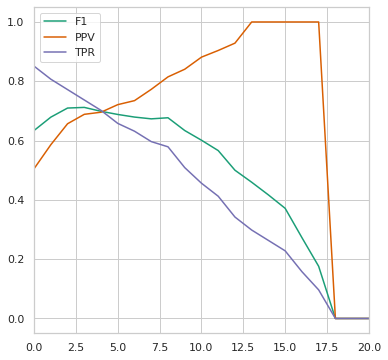

In [458]:
results_best_gs_model_tr = get_f1_thresholds(y_train, y_pred_proba_train_gs)
results_best_gs_model_tr[['F1','PPV','TPR']].plot()
plt.show()

Test set results:

In [461]:
y_pred_proba_test_gs = best_gs_model.predict_proba(X_test)[:, 1]

In [ ]:
print(classification_report(y_test, (y_pred_proba_test_gs > 0.5)))

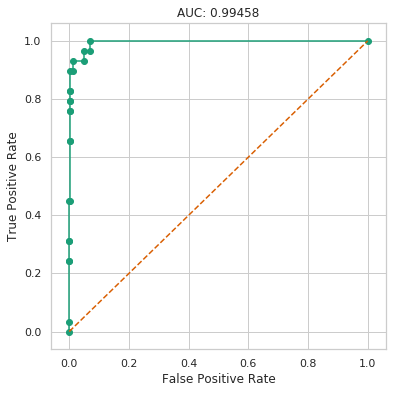

In [462]:
plot_roc_curve(y_test, y_pred_proba_test_gs)

In [463]:
threshold_f1 = get_best_threshold_for_F1(y_test, y_pred_proba_test_gs)
f1 = f1_score(y_test, (y_pred_proba_test_gs > threshold_f1))
print('Max F1 score: {:.4f} for threshold: {:.4f}'.format(f1, threshold_f1))

Max F1 score: 0.8000 for threshold: 0.4729


In [507]:
threshold_precision = get_best_threshold_for_precision(y_test, y_pred_proba_test_gs)
precision = precision_score(y_test, (y_pred_proba_test_gs > threshold_precision))
print('Max precision score: {:.4f} for threshold: {:.4f}'.format(precision, threshold_precision))

Max precision score: 1.0000 for threshold: 0.8818


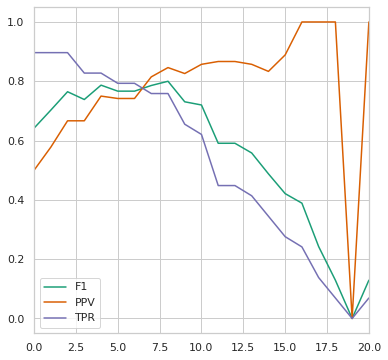

In [464]:
results_best_gs_model_te = get_f1_thresholds(y_test, y_pred_proba_test_gs)
results_best_gs_model_te[['F1','PPV','TPR']].plot()
plt.show()

In [465]:
results_best_gs_model_te

,threshold,F1,PPV,TPR
0,0.1000,0.641975,0.500000,0.896552
1,0.1500,0.702703,0.577778,0.896552
2,0.2000,0.764706,0.666667,0.896552
3,0.2500,0.738462,0.666667,0.827586
4,0.3000,0.786885,0.750000,0.827586
5,0.3500,0.766667,0.741935,0.793103
6,0.4000,0.766667,0.741935,0.793103
7,0.4500,0.785714,0.814815,0.758621
8,0.5000,0.800000,0.846154,0.758621
9,0.5500,0.730769,0.826087,0.655172


#### Best RandomForest model

In [514]:
rf_params = best_models1[0][0].get_params()
best_rf_model = RandomForestClassifier(**rf_params)
best_rf_model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 50},
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=15,
                       min_samples_split=15, min_weight_fraction_leaf=0.0,
                       n_estimators=50, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)

Train set results:

In [515]:
y_pred_proba_train_best_rf = best_rf_model.predict_proba(X_train)[:, 1]

In [ ]:
print(classification_report(y_train, (y_pred_proba_train_best_rf > 0.5)))

In [517]:
threshold_f1 = get_best_threshold_for_F1(y_train, y_pred_proba_train_best_rf)
f1 = f1_score(y_train, (y_pred_proba_train_best_rf > threshold_f1))
print('Max F1 score: {:.4f} for threshold: {:.4f}'.format(f1, threshold_f1))

Max F1 score: 0.7483 for threshold: 0.5170


In [519]:
threshold_precision = get_best_threshold_for_precision(y_train, y_pred_proba_train_best_rf)
precision = precision_score(y_train, (y_pred_proba_train_best_rf > threshold_precision))
print('Max F1 score: {:.4f} for threshold: {:.4f}'.format(precision, threshold_precision))

Max F1 score: 1.0000 for threshold: 0.9760


In [520]:
results_best_rf_tr = get_f1_thresholds(y_train, y_pred_proba_train_best_rf)

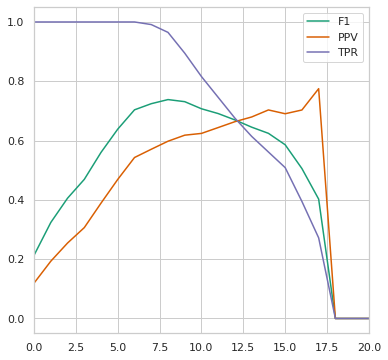

In [522]:
results_best_rf_tr[['F1','PPV','TPR']].plot()
plt.show()

Test set results:

In [523]:
y_pred_proba_test_best_rf  = best_rf_model.predict_proba(X_test)[:, 1]

In [ ]:
print(classification_report(y_test, (y_pred_proba_test_best_rf > 0.5)))

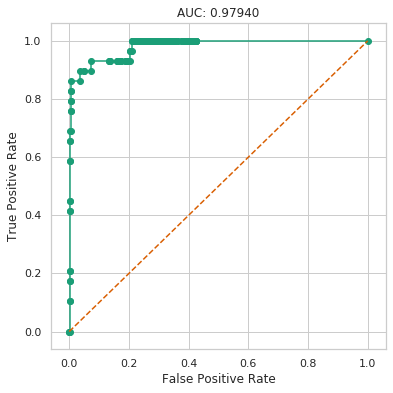

In [524]:
plot_roc_curve(y_test, y_pred_proba_test_best_rf)

In [525]:
threshold_f1 = get_best_threshold_for_F1(y_test, y_pred_proba_test_best_rf)
f1 = f1_score(y_test, (y_pred_proba_test_best_rf > threshold_f1))
print('Max F1 score: {:.4f} for threshold: {:.4f}'.format(f1, threshold_f1))

Max F1 score: 0.6575 for threshold: 0.5271


In [526]:
threshold_precision = get_best_threshold_for_precision(y_test, y_pred_proba_test_best_rf)
precision = precision_score(y_test, (y_pred_proba_test_best_rf > threshold_precision))
print('Max precision score: {:.4f} for threshold: {:.4f}'.format(precision, threshold_f1))

Max precision score: 0.6316 for threshold: 0.5271


In [527]:
results_best_rf_te = get_f1_thresholds(y_test, y_pred_proba_test_best_rf)

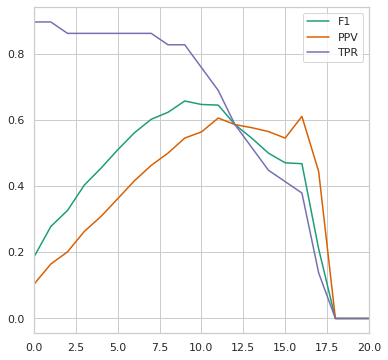

In [528]:
results_best_rf_te[['F1','PPV','TPR']].plot()
plt.show()

In [529]:
results_best_rf_te

,threshold,F1,PPV,TPR
0,0.1000,0.186380,0.104000,0.896552
1,0.1500,0.278075,0.164557,0.896552
2,0.2000,0.326797,0.201613,0.862069
3,0.2500,0.403226,0.263158,0.862069
4,0.3000,0.454545,0.308642,0.862069
5,0.3500,0.510204,0.362319,0.862069
6,0.4000,0.561798,0.416667,0.862069
7,0.4500,0.602410,0.462963,0.862069
8,0.5000,0.623377,0.500000,0.827586
9,0.5500,0.657534,0.545455,0.827586


#### Best SVM (rbf) model

In [530]:
svm2_params = best_models1[1][0].get_params()

In [531]:
best_svm2_model = SVC(**svm_params)
best_svm2_model.fit(X_train, y_train)

SVC(C=1, cache_size=200, class_weight={0: 1, 1: 1}, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=True, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

Train set results:

In [532]:
y_pred_proba_train_bestsvm2 = best_svm2_model.predict_proba(X_train)[:, 1]

In [533]:
print(classification_report(y_train, (y_pred_proba_train_bestsvm2 > 0.5)))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00     13258
           1       0.91      0.09      0.16       114

    accuracy                           0.99     13372
   macro avg       0.95      0.54      0.58     13372
weighted avg       0.99      0.99      0.99     13372



In [534]:
threshold_f1 = get_best_threshold_for_F1(y_train, y_pred_proba_train_bestsvm2)
f1 = f1_score(y_train, (y_pred_proba_train_bestsvm2 > threshold_f1))
print('Max F1 score: {:.4f} for threshold: {:.4f}'.format(f1, threshold_f1))

Max F1 score: 0.6639 for threshold: 0.0381


In [535]:
threshold_precision = get_best_threshold_for_precision(y_train, y_pred_proba_train_bestsvm2)
precision = precision_score(y_train, (y_pred_proba_train_bestsvm2 > threshold_precision))
print('Max precision score: {:.4f} for threshold: {:.4f}'.format(precision, threshold_precision))

Max precision score: 1.0000 for threshold: 0.5912


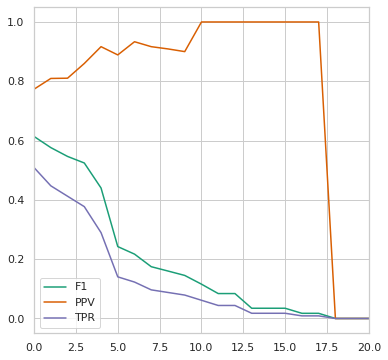

In [536]:
results_bestsvm2_tr = get_f1_thresholds(y_train, y_pred_proba_train_bestsvm2)
results_bestsvm2_tr[['F1','PPV','TPR']].plot()
plt.show()

Test set results:

In [537]:
y_pred_proba_test_bestsvm2 = best_svm2_model.predict_proba(X_test)[:, 1]

In [538]:
print(classification_report(y_test, (y_pred_proba_test_bestsvm2 > 0.5)))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      3314
           1       0.50      0.10      0.17        29

    accuracy                           0.99      3343
   macro avg       0.75      0.55      0.58      3343
weighted avg       0.99      0.99      0.99      3343



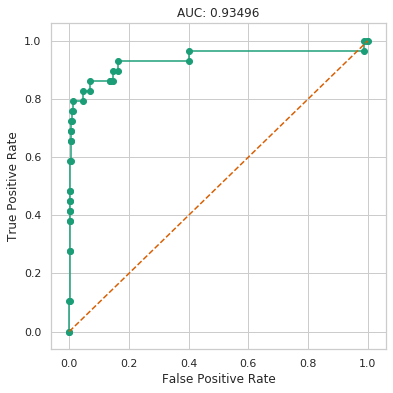

In [539]:
plot_roc_curve(y_test, y_pred_proba_test_bestsvm2)

In [540]:
threshold_f1 = get_best_threshold_for_F1(y_test, y_pred_proba_test_bestsvm2)
f1 = f1_score(y_test, (y_pred_proba_test_bestsvm2 > threshold_f1))
print('Test set F1 score: {:.4f} for threshold: {:.4f}'.format(f1, threshold_f1))

Test set F1 score: 0.5970 for threshold: 0.0641


In [541]:
threshold_precision = get_best_threshold_for_precision(y_test, y_pred_proba_test_bestsvm2)
precision = precision_score(y_test, (y_pred_proba_test_bestsvm2 > threshold_precision))
print('Test set precision score: {:.4f} for threshold: {:.4f}'.format(precision, threshold_precision))

Test set precision score: 0.7500 for threshold: 0.5872


In [542]:
results_bestsvm2_te = get_f1_thresholds(y_test, y_pred_proba_test_bestsvm2)

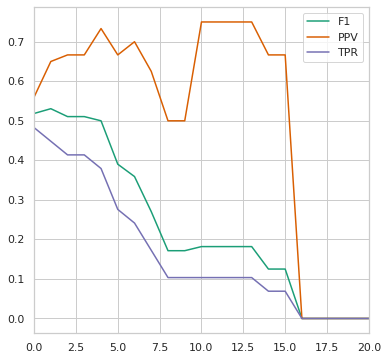

In [543]:
results_bestsvm2_te[['F1','PPV','TPR']].plot()
plt.show()

In [544]:
results_bestsvm2_te

,threshold,F1,PPV,TPR
0,0.1000,0.518519,0.560000,0.482759
1,0.1500,0.530612,0.650000,0.448276
2,0.2000,0.510638,0.666667,0.413793
3,0.2500,0.510638,0.666667,0.413793
4,0.3000,0.500000,0.733333,0.379310
5,0.3500,0.390244,0.666667,0.275862
6,0.4000,0.358974,0.700000,0.241379
7,0.4500,0.270270,0.625000,0.172414
8,0.5000,0.171429,0.500000,0.103448
9,0.5500,0.171429,0.500000,0.103448


#### Best SVM (linear) model

In [474]:
svm_params = best_models[1][0].get_params()

In [475]:
best_svm_model = SVC(**svm_params)
best_svm_model.fit(X_train, y_train)

SVC(C=1, cache_size=200, class_weight={0: 1, 1: 1}, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=True, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

Train set results:

In [477]:
y_pred_proba_train_bestsvm = best_svm_model.predict_proba(X_train)[:, 1]

In [478]:
print(classification_report(y_train, (y_pred_proba_train_bestsvm > 0.5)))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00     13258
           1       0.92      0.19      0.32       114

    accuracy                           0.99     13372
   macro avg       0.95      0.60      0.66     13372
weighted avg       0.99      0.99      0.99     13372



In [479]:
threshold_f1 = get_best_threshold_for_F1(y_train, y_pred_proba_train_bestsvm)
f1 = f1_score(y_train, (y_pred_proba_train_bestsvm > threshold_f1))
print('Max F1 score: {:.4f} for threshold: {:.4f}'.format(f1, threshold_f1))

Max F1 score: 0.7478 for threshold: 0.0842


In [482]:
threshold_precision = get_best_threshold_for_precision(y_train, y_pred_proba_train_bestsvm)
precision = precision_score(y_train, (y_pred_proba_train_bestsvm > threshold_precision))
print('Max precision score: {:.4f} for threshold: {:.4f}'.format(precision, threshold_precision))

Max precision score: 1.0000 for threshold: 0.5832


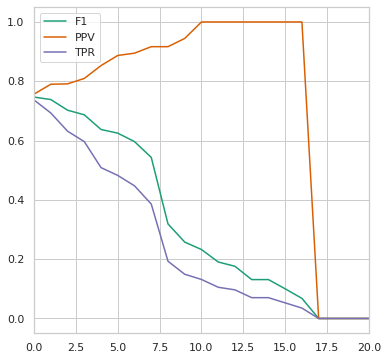

In [483]:
results_bestsvm_tr = get_f1_thresholds(y_train, y_pred_proba_train_bestsvm)
results_bestsvm_tr[['F1','PPV','TPR']].plot()
plt.show()

Test set results:

In [484]:
y_pred_proba_test_bestsvm = best_svm_model.predict_proba(X_test)[:, 1]

In [485]:
print(classification_report(y_test, (y_pred_proba_test_bestsvm > 0.5)))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      3314
           1       0.88      0.24      0.38        29

    accuracy                           0.99      3343
   macro avg       0.93      0.62      0.69      3343
weighted avg       0.99      0.99      0.99      3343



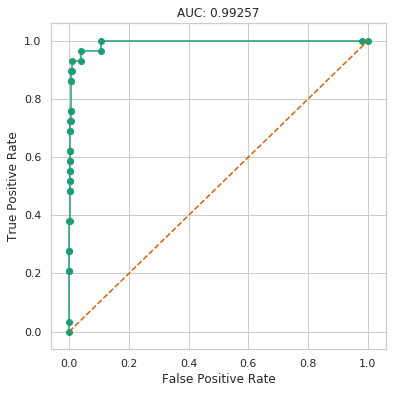

In [486]:
plot_roc_curve(y_test, y_pred_proba_test_bestsvm)

In [487]:
threshold_f1 = get_best_threshold_for_F1(y_test, y_pred_proba_test_bestsvm)
f1 = f1_score(y_test, (y_pred_proba_test_bestsvm > threshold_f1))
print('Test set F1 score: {:.4f} for threshold: {:.4f}'.format(f1, threshold_f1))

Test set F1 score: 0.6753 for threshold: 0.0621


In [488]:
threshold_precision = get_best_threshold_for_precision(y_test, y_pred_proba_test_bestsvm)
precision = precision_score(y_test, (y_pred_proba_test_bestsvm > threshold_precision))
print('Test set precision score: {:.4f} for threshold: {:.4f}'.format(precision, threshold_precision))

Test set precision score: 1.0000 for threshold: 0.6212


In [490]:
results_bestsvm_te = get_f1_thresholds(y_test, y_pred_proba_test_bestsvm)

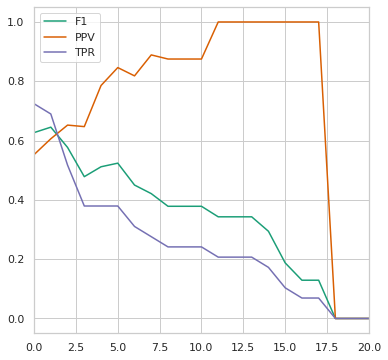

In [491]:
results_bestsvm_te[['F1','PPV','TPR']].plot()
plt.show()

In [492]:
results_bestsvm_te

,threshold,F1,PPV,TPR
0,0.1000,0.626866,0.552632,0.724138
1,0.1500,0.645161,0.606061,0.689655
2,0.2000,0.576923,0.652174,0.517241
3,0.2500,0.478261,0.647059,0.379310
4,0.3000,0.511628,0.785714,0.379310
5,0.3500,0.523810,0.846154,0.379310
6,0.4000,0.450000,0.818182,0.310345
7,0.4500,0.421053,0.888889,0.275862
8,0.5000,0.378378,0.875000,0.241379
9,0.5500,0.378378,0.875000,0.241379


### Cross validation undersampling

In [565]:
from copy import deepcopy

def cv_repeated_undersampling(X, 
                              y, 
                              model, 
                              size=1, 
                              n_estimators=20, 
                              cv=StratifiedKFold(5)):
    
    y_pred_proba = []
    y_true = []
    
    for train_idx, test_idx in cv.split(X, y):
        
        X_train, X_test = X.iloc[train_idx, :], X.iloc[test_idx, :]
        y_train, y_test = y[train_idx], y[test_idx]
        
        class_0_indexes = np.where(y_train==0)[0]
        class_1_amount = np.sum((y_train==1).astype(int))
        class_0_indexes_number = int(size * class_1_amount)
        
        y_pred_proba_cv = np.zeros((n_estimators, len(y_test)))
        
        for i in range(n_estimators):
        
            idx0 = np.random.choice(class_0_indexes, class_0_indexes_number, replace=False)
            idx1 = np.where(y_train==1)[0]
            idx_all = np.r_[idx0, idx1]

            X_train_sub = X_train.iloc[idx_all, :]
            y_train_sub = y_train[idx_all]

            model_tmp = deepcopy(model)
            model_tmp.fit(X_train_sub, y_train_sub)
            y_prob = model_tmp.predict_proba(X_test)[:, 1]
            y_pred_proba_cv[i,:] = y_prob
        
        y_pred_proba_cv_mean = y_pred_proba_cv.mean(0)
        
        y_pred_proba.extend(y_pred_proba_cv_mean.tolist())
        y_true.extend(y_test.tolist())
        
    return np.array(y_pred_proba), np.array(y_true)

In [571]:
def predict_with_repeated_undersampling(X_train, 
                                        y_train, 
                                        X_test, 
                                        model, 
                                        size=1, 
                                        n_estimators=20):    
        
    y_pred_proba_matrix = np.zeros((n_estimators, X_test.shape[0]))

    for i in range(n_estimators):
        class_0_indexes = np.where(y_train==0)[0]
        class_1_amount = np.sum((y_train==1).astype(int))
        class_0_indexes_number = int(size * class_1_amount)

        idx0 = np.random.choice(class_0_indexes, class_0_indexes_number, replace=False)
        idx1 = np.where(y_train==1)[0]
        idx_all = np.r_[idx0, idx1]

        X_train_sub = X_train.iloc[idx_all, :]
        y_train_sub = y_train[idx_all]

        model_tmp = deepcopy(model)
        model_tmp.fit(X_train_sub, y_train_sub)
        y_prob = model_tmp.predict_proba(X_test)[:, 1]
        y_pred_proba_matrix[i,:] = y_prob

    y_pred_proba_mean = y_pred_proba_matrix.mean(0)
        
    return y_pred_proba_mean

In [567]:
from sklearn.model_selection import ParameterGrid

#### First iteration of undersampling grid search

In [591]:
hyperparams = [
    {
       'model': LogisticRegression(),
        'grid': {
            'C': [0.001, 0.01, 0.1, 1, 10, 100], 
            'penalty': ['l1', 'l2']
         }
    },
    {
        'model': RandomForestClassifier(),
        'grid': {
            'n_estimators': [50], 
            'max_depth': [10, 20, 40],
            'min_samples_leaf': [15, 20, 40],
            'min_samples_split': [15, 20, 40]
         },
              
        
    }
    
    
]

In [601]:
def undersampling_grid_search(hyperparams):
    best_f1_score_models = []
 

    for params in hyperparams:
        pg = ParameterGrid(params['grid'])
        models = []
        f1_scores = []
        precision_scores = []
        print('model: {}'.format(params['model'].__class__.__name__))
        for idx, combination in enumerate(pg):
            
            model = params['model']
            model.set_params(**combination)
            y_pred_proba_cv_us, y_cv = cv_repeated_undersampling(X=X_train, 
                                                                 y=y_train, 
                                                                 model=model,
                                                                 n_estimators=100, 
                                                                 size=2, 
                                                                 cv=StratifiedKFold(3))
            y_pred_proba_test_us = predict_with_repeated_undersampling(X_train, 
                                                                       y_train, 
                                                                       X_test, 
                                                                       model=model, 
                                                                       n_estimators=100, 
                                                                       size=2)

            threshold_f1 = get_best_threshold_for_F1(y_cv, y_pred_proba_cv_us)
         

            f1_scores.append(f1_score(y_test, (y_pred_proba_test_us > threshold_f1)))
         
            

            models.append(model)

        best_f1_score_model_idx = np.argmax(np.array(f1_scores))

        

        best_f1_score_models.append({
            'model': models[best_f1_score_model_idx],
            'F1': f1_scores[best_f1_score_model_idx]
        })
        
    return best_f1_score_models

In [602]:
best_f1_score_models = undersampling_grid_search(hyperparams)

model: LogisticRegression
model: RandomForestClassifier


In [605]:
best_f1_score_models

[{'model': LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
                     intercept_scaling=1, l1_ratio=None, max_iter=100,
                     multi_class='warn', n_jobs=None, penalty='l2',
                     random_state=None, solver='warn', tol=0.0001, verbose=0,
                     warm_start=False), 'F1': 0.676923076923077},
 {'model': RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                         max_depth=40, max_features='auto', max_leaf_nodes=None,
                         min_impurity_decrease=0.0, min_impurity_split=None,
                         min_samples_leaf=40, min_samples_split=40,
                         min_weight_fraction_leaf=0.0, n_estimators=50,
                         n_jobs=None, oob_score=False, random_state=None,
                         verbose=0, warm_start=False),
  'F1': 0.4482758620689655}]

Chosen hiperparameter values lie on boundaires of given space, therefore hiperparameters space should be broaden. Nevertheless, best models and their performance are shown below.

#### Best LogisticRegression models

In [606]:
us_params = best_f1_score_models[0]['model'].get_params()
us_params

{'C': 100,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'warn',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'warn',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [607]:
best_us3_model = LogisticRegression(**us_params)

Train set results:

In [610]:
y_pred_proba_train_us3 = predict_with_repeated_undersampling(X_train, 
                                                            y_train, 
                                                            X_train, 
                                                            model=best_us3_model,
                                                            n_estimators=100,
                                                            size=2)

In [611]:
print(classification_report(y_train, (y_pred_proba_train_us3 > 0.5)))

              precision    recall  f1-score   support

           0       1.00      0.90      0.95     13258
           1       0.08      0.96      0.14       114

    accuracy                           0.90     13372
   macro avg       0.54      0.93      0.55     13372
weighted avg       0.99      0.90      0.94     13372



In [612]:
threshold_f1 = get_best_threshold_for_F1(y_train, y_pred_proba_train_us3)
f1 = f1_score(y_train, (y_pred_proba_train_us3 > threshold_f1))
print('Max F1 score: {:.4f} for threshold: {:.4f}'.format(f1, threshold_f1))

Max F1 score: 0.7826 for threshold: 0.9860


In [613]:
threshold_precision = get_best_threshold_for_precision(y_train, y_pred_proba_train_us3)
precision = precision_score(y_train, (y_pred_proba_train_us3 > threshold_precision))
print('Max precision score: {:.4f} for threshold: {:.4f}'.format(precision, threshold_precision))

Max precision score: 0.9841 for threshold: 0.9940


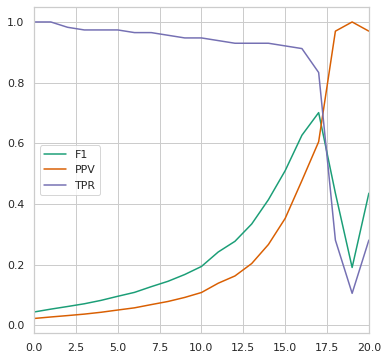

In [614]:
results_best_us3_tr = get_f1_thresholds(y_train, y_pred_proba_train_us3)
results_best_us3_tr[['F1','PPV','TPR']].plot()
plt.show()

Test set results:

In [615]:
y_pred_proba_test_us3 = predict_with_repeated_undersampling(X_train, 
                                                           y_train, 
                                                           X_test,
                                                           model=best_us3_model,
                                                           n_estimators=100,
                                                           size=2)

In [618]:
print(classification_report(y_test, (y_pred_proba_test_us3 > 0.5)))

              precision    recall  f1-score   support

           0       1.00      0.90      0.95      3314
           1       0.08      0.97      0.14        29

    accuracy                           0.90      3343
   macro avg       0.54      0.93      0.55      3343
weighted avg       0.99      0.90      0.94      3343



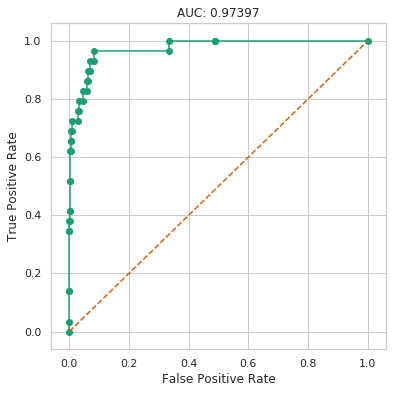

In [617]:
plot_roc_curve(y_test, y_pred_proba_test_us3)

In [619]:
threshold_f1 = get_best_threshold_for_F1(y_test, y_pred_proba_test_us3)
f1 = f1_score(y_test, (y_pred_proba_test_us3 > threshold_f1))
print('Max F1 score: {:.4f} for threshold: {:.4f}'.format(f1, threshold_f1))

Max F1 score: 0.6545 for threshold: 0.9739


In [620]:
threshold_precision = get_best_threshold_for_F1(y_test, y_pred_proba_test_us3)
precision = precision_score(y_test, (y_pred_proba_test_us3 > threshold_precision))
print('Max precision score: {:.4f} for threshold: {:.4f}'.format(precision, threshold_precision))

Max precision score: 0.6923 for threshold: 0.9739


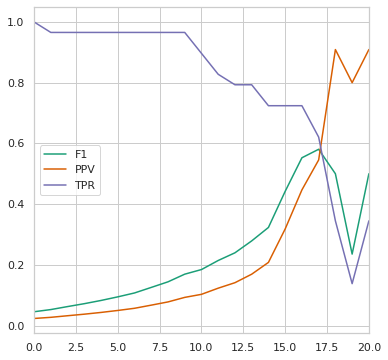

In [621]:
results_best_us3_te = get_f1_thresholds(y_test, y_pred_proba_test_us3)
results_best_us3_te[['F1','PPV','TPR']].plot()
plt.show()

In [622]:
results_best_us3_te

,threshold,F1,PPV,TPR
0,0.1000,0.045419,0.023237,1.000000
1,0.1500,0.052582,0.027027,0.965517
2,0.2000,0.062430,0.032258,0.965517
3,0.2500,0.071979,0.037383,0.965517
4,0.3000,0.082596,0.043143,0.965517
5,0.3500,0.094435,0.049645,0.965517
6,0.4000,0.107280,0.056795,0.965517
7,0.4500,0.125561,0.067146,0.965517
8,0.5000,0.143959,0.077778,0.965517
9,0.5500,0.169184,0.092715,0.965517


#### Best RandomForestClassifier model

In [623]:
us4_params = best_f1_score_models[1]['model'].get_params()
us4_params

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 40,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 40,
 'min_samples_split': 40,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 50,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [625]:
best_us4_model = RandomForestClassifier(**us4_params)

Train set results:

In [626]:
y_pred_proba_train_us4 = predict_with_repeated_undersampling(X_train, 
                                                            y_train, 
                                                            X_train,
                                                            model=best_us4_model,
                                                            n_estimators=100,
                                                            size=2)

In [627]:
print(classification_report(y_train, (y_pred_proba_train_us4 > 0.5)))

              precision    recall  f1-score   support

           0       1.00      0.96      0.98     13258
           1       0.10      0.58      0.17       114

    accuracy                           0.95     13372
   macro avg       0.55      0.77      0.57     13372
weighted avg       0.99      0.95      0.97     13372



In [628]:
threshold_f1 = get_best_threshold_for_F1(y_train, y_pred_proba_train_us4)
f1 = f1_score(y_train, (y_pred_proba_train_us4 > threshold_f1))
print('Max F1 score: {:.4f} for threshold: {:.4f}'.format(f1, threshold_f1))

Max F1 score: 0.4615 for threshold: 0.7415


In [629]:
threshold_precision = get_best_threshold_for_precision(y_train, y_pred_proba_train_us4)
precision = precision_score(y_train, (y_pred_proba_train_us4 > threshold_precision))
print('Max precision score: {:.4f} for threshold: {:.4f}'.format(precision, threshold_precision))

Max precision score: 0.6875 for threshold: 0.8477


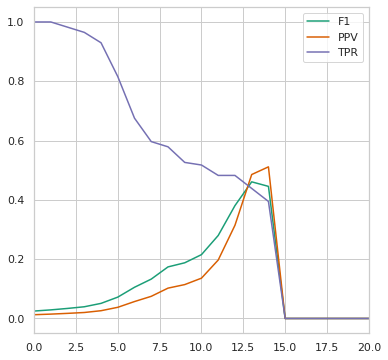

In [630]:
results_best_us4_tr = get_f1_thresholds(y_train, y_pred_proba_train_us4)
results_best_us4_tr[['F1','PPV','TPR']].plot()
plt.show()

Test set results:

In [631]:
y_pred_proba_test_us4 = predict_with_repeated_undersampling(X_train, 
                                                           y_train, 
                                                           X_test,
                                                           model=best_us4_model,
                                                           n_estimators=100,
                                                           size=2)

In [632]:
print(classification_report(y_test, (y_pred_proba_test_us4 > 0.5)))

              precision    recall  f1-score   support

           0       1.00      0.96      0.98      3314
           1       0.12      0.59      0.20        29

    accuracy                           0.96      3343
   macro avg       0.56      0.77      0.59      3343
weighted avg       0.99      0.96      0.97      3343



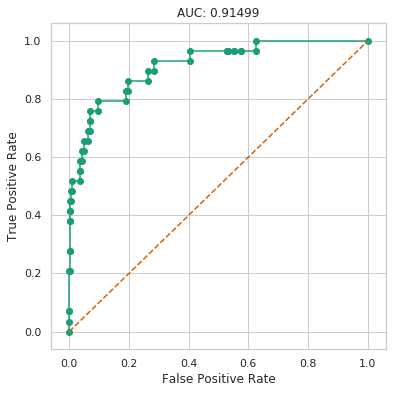

In [633]:
plot_roc_curve(y_test, y_pred_proba_test_us4)

In [634]:
threshold_f1 = get_best_threshold_for_F1(y_test, y_pred_proba_test_us4)
f1 = f1_score(y_test, (y_pred_proba_test_us4 > threshold_f1))
print('Max F1 score: {:.4f} for threshold: {:.4f}'.format(f1, threshold_f1))

Max F1 score: 0.4727 for threshold: 0.7515


In [637]:
threshold_precision = get_best_threshold_for_precision(y_test, y_pred_proba_test_us4)
precision = precision_score(y_test, (y_pred_proba_test_us4 > threshold_precision))
print('Max F1 score: {:.4f} for threshold: {:.4f}'.format(precision, threshold_precision))

Max F1 score: 1.0000 for threshold: 0.8477


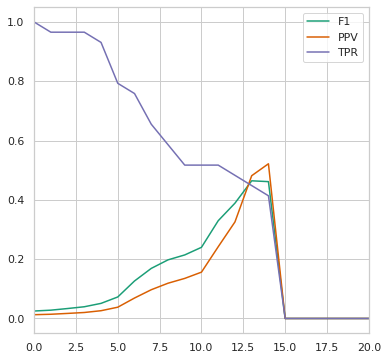

In [638]:
results_best_us4_te = get_f1_thresholds(y_test, y_pred_proba_test_us4)
results_best_us4_te[['F1','PPV','TPR']].plot()
plt.show()

In [648]:
results_best_us4_te

,threshold,F1,PPV,TPR
0,0.1000,0.025141,0.012730,1.000000
1,0.1500,0.028014,0.014213,0.965517
2,0.2000,0.033533,0.017063,0.965517
3,0.2500,0.039520,0.020173,0.965517
4,0.3000,0.050943,0.026188,0.931034
5,0.3500,0.072555,0.038017,0.793103
6,0.4000,0.126437,0.068966,0.758621
7,0.4500,0.168889,0.096939,0.655172
8,0.5000,0.197674,0.118881,0.586207
9,0.5500,0.214286,0.135135,0.517241


#### Second iteration of undersampling grid search

In [645]:
hyperparams2 = [
    {
       'model': LogisticRegression(),
        'grid': {
            'C': [100, 150, 200, 300], 
            'penalty': ['l1', 'l2']
         }
    },
    {
        'model': RandomForestClassifier(),
        'grid': {
            'n_estimators': [200], 
            'max_depth': [40, 70, 100],
            'min_samples_leaf': [40, 70, 100],
            'min_samples_split': [40, 70, 100]
         }
    }
]

In [646]:
best_f1_score_models = undersampling_grid_search(hyperparams2)

model: LogisticRegression
model: RandomForestClassifier


In [650]:
best_f1_score_models

[{'model': LogisticRegression(C=300, class_weight=None, dual=False, fit_intercept=True,
                     intercept_scaling=1, l1_ratio=None, max_iter=100,
                     multi_class='warn', n_jobs=None, penalty='l2',
                     random_state=None, solver='warn', tol=0.0001, verbose=0,
                     warm_start=False), 'F1': 0.6206896551724138},
 {'model': RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                         max_depth=100, max_features='auto', max_leaf_nodes=None,
                         min_impurity_decrease=0.0, min_impurity_split=None,
                         min_samples_leaf=100, min_samples_split=100,
                         min_weight_fraction_leaf=0.0, n_estimators=200,
                         n_jobs=None, oob_score=False, random_state=None,
                         verbose=0, warm_start=False),
  'F1': 0.3225806451612903}]

#### Best LogisticRegression models

In [651]:
us5_params = best_f1_score_models[0]['model'].get_params()
us5_params

{'C': 300,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'warn',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'warn',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [652]:
best_us5_model = LogisticRegression(**us5_params)

Train set results:

In [653]:
y_pred_proba_train_us5 = predict_with_repeated_undersampling(X_train, 
                                                            y_train, 
                                                            X_train, 
                                                            model=best_us5_model,
                                                            n_estimators=100,
                                                            size=2)

In [654]:
print(classification_report(y_train, (y_pred_proba_train_us5 > 0.5)))

              precision    recall  f1-score   support

           0       1.00      0.89      0.94     13258
           1       0.07      0.97      0.14       114

    accuracy                           0.90     13372
   macro avg       0.54      0.93      0.54     13372
weighted avg       0.99      0.90      0.94     13372



In [655]:
threshold_f1 = get_best_threshold_for_F1(y_train, y_pred_proba_train_us5)
f1 = f1_score(y_train, (y_pred_proba_train_us5 > threshold_f1))
print('Max F1 score: {:.4f} for threshold: {:.4f}'.format(f1, threshold_f1))

Max F1 score: 0.8269 for threshold: 0.9840


In [656]:
threshold_precision = get_best_threshold_for_precision(y_train, y_pred_proba_train_us5)
precision = precision_score(y_train, (y_pred_proba_train_us5 > threshold_precision))
print('Max precision score: {:.4f} for threshold: {:.4f}'.format(precision, threshold_precision))

Max precision score: 0.9848 for threshold: 0.9960


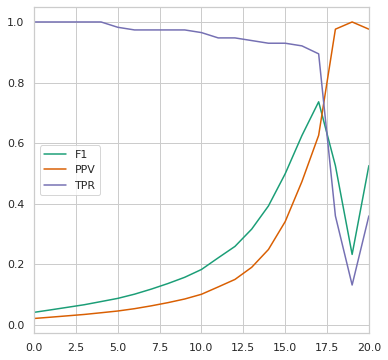

In [657]:
results_best_us5_tr = get_f1_thresholds(y_train, y_pred_proba_train_us5)
results_best_us5_tr[['F1','PPV','TPR']].plot()
plt.show()

Test set results:

In [658]:
y_pred_proba_test_us5 = predict_with_repeated_undersampling(X_train, 
                                                           y_train, 
                                                           X_test,
                                                           model=best_us5_model,
                                                           n_estimators=100,
                                                           size=2)

In [659]:
print(classification_report(y_test, (y_pred_proba_test_us5 > 0.5)))

              precision    recall  f1-score   support

           0       1.00      0.89      0.94      3314
           1       0.07      0.97      0.13        29

    accuracy                           0.89      3343
   macro avg       0.53      0.93      0.53      3343
weighted avg       0.99      0.89      0.93      3343



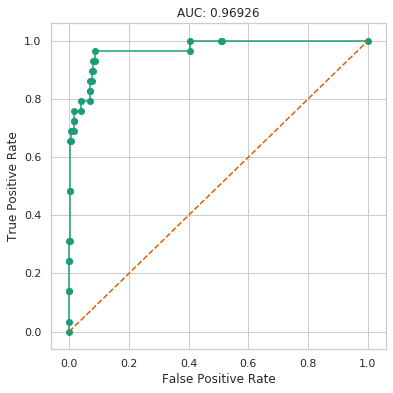

In [660]:
plot_roc_curve(y_test, y_pred_proba_test_us5)

In [661]:
threshold_f1 = get_best_threshold_for_F1(y_test, y_pred_proba_test_us5)
f1 = f1_score(y_test, (y_pred_proba_test_us5 > threshold_f1))
print('Max F1 score: {:.4f} for threshold: {:.4f}'.format(f1, threshold_f1))

Max F1 score: 0.6667 for threshold: 0.9659


In [662]:
threshold_precision = get_best_threshold_for_F1(y_test, y_pred_proba_test_us5)
precision = precision_score(y_test, (y_pred_proba_test_us5 > threshold_precision))
print('Max precision score: {:.4f} for threshold: {:.4f}'.format(precision, threshold_precision))

Max precision score: 0.6786 for threshold: 0.9659


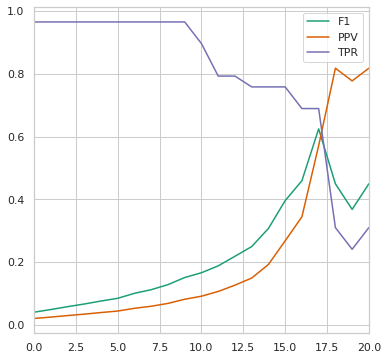

In [663]:
results_best_us5_te = get_f1_thresholds(y_test, y_pred_proba_test_us5)
results_best_us5_te[['F1','PPV','TPR']].plot()
plt.show()

In [664]:
results_best_us5_te

,threshold,F1,PPV,TPR
0,0.1000,0.040936,0.020911,0.965517
1,0.1500,0.049383,0.025339,0.965517
2,0.2000,0.058516,0.030172,0.965517
3,0.2500,0.066986,0.034696,0.965517
4,0.3000,0.076503,0.039829,0.965517
5,0.3500,0.085236,0.044586,0.965517
6,0.4000,0.101083,0.053333,0.965517
7,0.4500,0.112676,0.059829,0.965517
8,0.5000,0.128736,0.068966,0.965517
9,0.5500,0.151351,0.082111,0.965517


#### Best RandomForestClassifier model

In [665]:
us6_params = best_f1_score_models[1]['model'].get_params()
us6_params

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 100,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 100,
 'min_samples_split': 100,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 200,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [666]:
best_us6_model = RandomForestClassifier(**us6_params)

Train set results:

In [667]:
y_pred_proba_train_us6 = predict_with_repeated_undersampling(X_train, 
                                                            y_train, 
                                                            X_train,
                                                            model=best_us6_model,
                                                            n_estimators=100,
                                                            size=2)

In [668]:
print(classification_report(y_train, (y_pred_proba_train_us6 > 0.5)))

              precision    recall  f1-score   support

           0       1.00      0.81      0.89     13258
           1       0.03      0.64      0.05       114

    accuracy                           0.81     13372
   macro avg       0.51      0.72      0.47     13372
weighted avg       0.99      0.81      0.89     13372



In [669]:
threshold_f1 = get_best_threshold_for_F1(y_train, y_pred_proba_train_us6)
f1 = f1_score(y_train, (y_pred_proba_train_us6 > threshold_f1))
print('Max F1 score: {:.4f} for threshold: {:.4f}'.format(f1, threshold_f1))

Max F1 score: 0.2404 for threshold: 0.5451


In [670]:
threshold_precision = get_best_threshold_for_precision(y_train, y_pred_proba_train_us6)
precision = precision_score(y_train, (y_pred_proba_train_us6 > threshold_precision))
print('Max precision score: {:.4f} for threshold: {:.4f}'.format(precision, threshold_precision))

Max precision score: 0.6316 for threshold: 0.5471


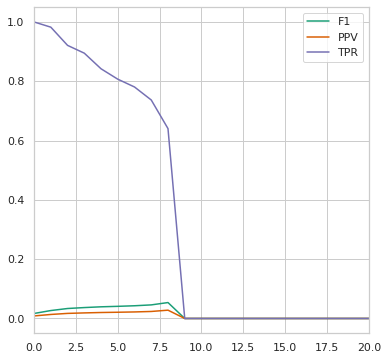

In [671]:
results_best_us6_tr = get_f1_thresholds(y_train, y_pred_proba_train_us6)
results_best_us6_tr[['F1','PPV','TPR']].plot()
plt.show()

Test set results:

In [672]:
y_pred_proba_test_us6 = predict_with_repeated_undersampling(X_train, 
                                                           y_train, 
                                                           X_test,
                                                           model=best_us6_model,
                                                           n_estimators=100,
                                                           size=2)

In [673]:
print(classification_report(y_test, (y_pred_proba_test_us6 > 0.5)))

              precision    recall  f1-score   support

           0       1.00      0.81      0.89      3314
           1       0.03      0.76      0.06        29

    accuracy                           0.81      3343
   macro avg       0.52      0.78      0.48      3343
weighted avg       0.99      0.81      0.89      3343



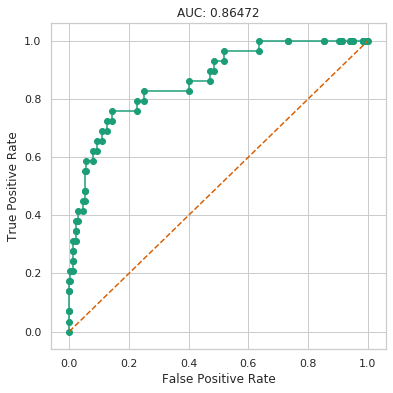

In [674]:
plot_roc_curve(y_test, y_pred_proba_test_us6)

In [675]:
threshold_f1 = get_best_threshold_for_F1(y_test, y_pred_proba_test_us6)
f1 = f1_score(y_test, (y_pred_proba_test_us6 > threshold_f1))
print('Max F1 score: {:.4f} for threshold: {:.4f}'.format(f1, threshold_f1))

Max F1 score: 0.2632 for threshold: 0.5451


In [681]:
threshold_precision = get_best_threshold_for_precision(y_test, y_pred_proba_test_us6)
precision = precision_score(y_test, (y_pred_proba_test_us6 > threshold_precision))
print('Max precision score: {:.4f} for threshold: {:.4f}'.format(precision, threshold_precision))

Max precision score: 1.0000 for threshold: 0.5471


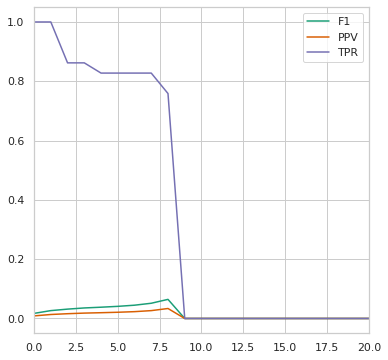

In [677]:
results_best_us6_te = get_f1_thresholds(y_test, y_pred_proba_test_us6)
results_best_us6_te[['F1','PPV','TPR']].plot()
plt.show()

In [678]:
results_best_us6_te

,threshold,F1,PPV,TPR
0,0.1000,0.017200,0.008675,1.000000
1,0.1500,0.026508,0.013432,1.000000
2,0.2000,0.031546,0.016067,0.862069
3,0.2500,0.035486,0.018116,0.862069
4,0.3000,0.038005,0.019449,0.827586
5,0.3500,0.040886,0.020961,0.827586
6,0.4000,0.044776,0.023011,0.827586
7,0.4500,0.051337,0.026490,0.827586
8,0.5000,0.064422,0.033639,0.758621
9,0.5500,0.000000,0.000000,0.000000


### PCA - Principal Component Analysis

I was trying to implement PCA on the dataset but it was impossible due to a lack of memory. Additionaly I realized that PCA would lead to loss of information about individual atributes which may also be important in this case.

### Results

In [679]:
results = pd.DataFrame({
    'model': ['model_lr', 'model_lrw', 'model_lrl', 'model_lr_thres', 'model_lrw_thres', 'model_lrl_thres', 'model_lr_550', 'model_lrw_550', 'model_lrl_550', 'model_lr_RFE', 'model_RF_144', 'model_svm_rbf', 'model_svm_lin',  'model_und_lr', 'model_und_rf',  'model_und2_lr', 'model_und2_rf'],
    'F1_test' : [0.48, 0.42, 0.62, 0.5246, 0.4727, 0.6545, 0.6667, 0.4800, 0.6923, 0.8000, 0.6575, 0.5970, 0.6753, 0.6545, 0.4727, 0.6667, 0.2632],
    'precision_test' : [0.48, 0.30, 0.70, 0.6250, 0.500, 0.9231, 0.6875, 0.4483, 1.0000, 1.0000,  0.6316, 0.7500, 1.0000, 0.6923, 1.0000, 0.6786, 0.1000]
    
})

In [680]:
results

,model,F1_test,precision_test
0,model_lr,0.4800,0.4800
1,model_lrw,0.4200,0.3000
2,model_lrl,0.6200,0.7000
3,model_lr_thres,0.5246,0.6250
4,model_lrw_thres,0.4727,0.5000
5,model_lrl_thres,0.6545,0.9231
6,model_lr_550,0.6667,0.6875
7,model_lrw_550,0.4800,0.4483
8,model_lrl_550,0.6923,1.0000
9,model_lr_RFE,0.8000,1.0000


#### The best model in F1 and precision is model #9 Logistic Regression model with 150 features selected by RFE: F1 = 0.8, PPV = 1.